In [ ]:
import numpy as np
import numba
import umap
import pynndescent

print("NumPy version:", np.__version__)
print("Numba version:", numba.__version__)
print("UMAP version:", umap.__version__)
print("PyNNDescent version:", pynndescent.__version__)


In [10]:
import os
import json
import ale_py

import torch as T
import torch.nn as nn
from torch import optim
import numpy as np
# import pandas as pd
# from umap import UMAP


import torch_utils
from torch import distributions

import gymnasium as gym
import gymnasium_robotics
from gymnasium.vector import VectorEnv, SyncVectorEnv
# import models
from models import ValueModel, StochasticContinuousPolicy, ActorModel, CriticModel, StochasticDiscretePolicy
from rl_agents import PPO, DDPG, Reinforce, ActorCritic, TD3, HER
import rl_callbacks
from rl_callbacks import WandbCallback
# from helper import Normalizer
from buffer import ReplayBuffer
from noise import NormalNoise
import gym_helper
import wandb_support
import wandb
import gym_helper
import dash_utils
from env_wrapper import EnvWrapper, GymnasiumWrapper
from schedulers import ScheduleWrapper

import matplotlib.pyplot as plt

# from mpi4py import MPI

In [ ]:
import mujoco

In [ ]:
print(f'mujoco version: {mujoco.__version__}')

In [ ]:
env = gym.make('FetchReach-v4')
env_spec = env.spec
wrap_env = GymnasiumWrapper(env_spec)

In [ ]:
state, _ = env.reset()

In [ ]:
env.env.env.env.initial_qpos

In [ ]:
wrap_env.env = wrap_env._initialize_env(num_envs=8)

In [ ]:
states, _ = wrap_env.reset()

In [ ]:
states

In [ ]:
mujoco.MjModel

In [ ]:
gym_robo.__version__

In [ ]:
def check_cuda():
    cuda_available = T.cuda.is_available()
    if cuda_available:
        print("CUDA is available.")
        num_gpus = T.cuda.device_count()
        print(f"Number of GPUs detected: {num_gpus}")
        
        for i in range(num_gpus):
            gpu_name = T.cuda.get_device_name(i)
            gpu_memory = T.cuda.get_device_properties(i).total_memory / (1024 ** 3)  # Convert bytes to GB
            print(f"GPU {i}: {gpu_name}")
            print(f"Total memory: {gpu_memory:.2f} GB")
    else:
        print("CUDA is not available.")

check_cuda()

In [ ]:
def get_default_device():
    """Returns the default device for computations, GPU if available, otherwise CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

device = get_default_device()
print(f"Using device: {device}")

# TEST

In [ ]:
gym_robo.register_robotics_envs()

In [ ]:
gym.register_envs(gymnasium_robotics)

In [ ]:
gym.envs.registration.registry

In [ ]:
wandb.login(key='758ac5ba01e12a3df504d2db2fec8ba4f391f7e6')

In [ ]:
env = gym.make('FetchPush-v2', max_episode_steps=100, render_mode='rgb_array')
env = gym.wrappers.RecordVideo(env, 'test/', episode_trigger=lambda i: i%1==0)

episodes = 10


for episode in range(episodes):
    done = False
    obs, _ = env.reset()
    while not done:
        obs, r, term, trunc, dict = env.step(env.action_space.sample())
        if term or trunc:
            done = True
env.close()

In [ ]:
env = gym.make("FetchReach-v2")
env.reset()
obs, reward, terminated, truncated, info = env.step(env.action_space.sample())

# The following always has to hold:
assert reward == env.compute_reward(obs["achieved_goal"], obs["desired_goal"], info)
assert truncated == env.compute_truncated(obs["achieved_goal"], obs["desired_goal"], info)
assert terminated == env.compute_terminated(obs["achieved_goal"], obs["desired_goal"], info)

In [ ]:
env.compute_reward()

In [ ]:
env = gym.make('FetchPush-v2', render_mode='rgb_array')

In [ ]:
if hasattr(env, "distance_threshold"):
    print('true')
else:
    print('false')

In [ ]:
if env.get_wrapper_attr("distance_threshold"):
    print('true')

In [ ]:
print(dir(env))


# DDPG

In [ ]:
# env = gym.make('BipedalWalker-v3')
env = gym.make('Pendulum-v1')
env_spec = env.spec
env_wrap = GymnasiumWrapper(env_spec)

In [ ]:
for e in env_wrap.env.envs:
    print(e.spec)

In [ ]:
# build actor
device = 'cuda'
optimizer = {'type': 'Adam','params': { 'lr': 0.001 }}

layer_config = [
    {'type': 'dense', 'params': {'units': 400, 'kernel': 'variance_scaling', 'kernel params':{"scale": 1.0, "mode": "fan_in", "distribution": "uniform"}}},
    {'type': 'relu'},
    {'type': 'dense', 'params': {'units': 300, 'kernel': 'variance_scaling', 'kernel params':{"scale": 1.0, "mode": "fan_in", "distribution": "uniform"}}},
    {'type': 'relu'},
]
output_layer_config = [{'type': 'dense', 'params': {'kernel': 'default', 'kernel params':{}}}]

actor = ActorModel(env_wrap, layer_config, output_layer_config, device=device)

In [ ]:
actor

In [ ]:
# build critic

state_layer_config = [
    {'type': 'dense', 'params': {'units': 400, 'kernel': 'variance_scaling', 'kernel params':{"scale": 1.0, "mode": "fan_in", "distribution": "uniform"}}},
    {'type': 'relu'}
]

merged_layer_config = [
    {'type': 'dense', 'params': {'units': 300, 'kernel': 'variance_scaling', 'kernel params':{"scale": 1.0, "mode": "fan_in", "distribution": "uniform"}}},
    {'type': 'relu'},
]
# output_layer_config = {'type': 'dense', 'params': {'kernel': 'default', 'kernel params':{}}},

critic = CriticModel(env_wrap, state_layers=state_layer_config, merged_layers=merged_layer_config,
                    output_layer_kernel=output_layer_config, optimizer_params=optimizer, device=device)

In [ ]:
critic

In [ ]:
replay_buffer = ReplayBuffer(env_wrap, 100000, device=device)
noise = NormalNoise(shape=env_wrap.action_space.shape, device=device)

In [ ]:
replay_buffer.get_config()

In [ ]:
noise.get_config()

In [ ]:
ddpg_agent = DDPG(env=env_wrap,
                actor_model=actor,
                critic_model=critic,
                replay_buffer=replay_buffer,
                discount=0.99,
                tau=0.005,
                action_epsilon=0.2,
                noise=noise,
                callbacks=[rl_callbacks.WandbCallback('Pendulum-v1')],
                device=device)

In [ ]:
ddpg_agent.critic_model

In [ ]:
ddpg_agent.target_critic_model

In [ ]:
ddpg_agent.train(1000, 8, 42, 50)

In [ ]:
ddpg_agent.test(10, True, 1)

In [ ]:
config_file_path = '/workspaces/RL_Agents/src/app/models/ddpg/config.json'
with open(config_file_path, 'r') as file:
    config = json.load(file)

In [ ]:
ddpg = DDPG.load(config)

In [ ]:
ddpg.get_config()

In [ ]:
ddpg.test(10, 1)

# TD3

In [ ]:
# env = gym.make('BipedalWalker-v3')
env = gym.make('Pendulum-v1')
env_spec = env.spec
env_wrap = GymnasiumWrapper(env_spec)

In [ ]:
# build actor
device = 'cuda'
optimizer = {'type': 'Adam','params': { 'lr': 0.001 }}

layer_config = [
    {'type': 'dense', 'params': {'units': 400, 'kernel': 'variance_scaling', 'kernel params':{"scale": 1.0, "mode": "fan_in", "distribution": "uniform"}}},
    {'type': 'relu'},
    {'type': 'dense', 'params': {'units': 300, 'kernel': 'variance_scaling', 'kernel params':{"scale": 1.0, "mode": "fan_in", "distribution": "uniform"}}},
    {'type': 'relu'},
]
output_layer_config = [{'type': 'dense', 'params': {'kernel': 'default', 'kernel params':{}}}]

actor = ActorModel(env_wrap, layer_config, output_layer_config, device=device)

In [ ]:
# build critic

state_layer_config = [
    {'type': 'dense', 'params': {'units': 400, 'kernel': 'variance_scaling', 'kernel params':{"scale": 1.0, "mode": "fan_in", "distribution": "uniform"}}},
    {'type': 'relu'}
]

merged_layer_config = [
    {'type': 'dense', 'params': {'units': 300, 'kernel': 'variance_scaling', 'kernel params':{"scale": 1.0, "mode": "fan_in", "distribution": "uniform"}}},
    {'type': 'relu'},
]
# output_layer_config = {'type': 'dense', 'params': {'kernel': 'default', 'kernel params':{}}},

critic = CriticModel(env_wrap, state_layers=state_layer_config, merged_layers=merged_layer_config,
                    output_layer_kernel=output_layer_config, optimizer_params=optimizer, device=device)

In [ ]:
replay_buffer = ReplayBuffer(env_wrap, 100000, device=device)
noise = NormalNoise(shape=env_wrap.action_space.shape, device=device)

In [ ]:
td3 = TD3(
    env=env_wrap,
    actor_model=actor,
    critic_model=critic,
    discount=0.99,
    tau=0.005,
    action_epsilon=0.2,
    replay_buffer=replay_buffer,
    noise=noise,
    callbacks=[rl_callbacks.WandbCallback('Pendulum-v1')],
    device='cuda'
)

In [ ]:
td3.get_config()

In [ ]:
td3.train(200, 8, 42, 50)

In [ ]:
float(td3.env.action_space.low[-1])

# HER/DDPG

In [ ]:
print(f'gym robotics version: {gym_robo.__version__}')

In [ ]:
# Create the environment
env = gym.make('FetchPickAndPlace-v4', render_mode='human')
env_spec = env.spec
env = GymnasiumWrapper(env_spec)
env.env = env._initialize_env(1, 2)

# Reset the environment and get initial observation
obs, _ = env.reset()  # Use no seed for randomness
for i in range(env.env.num_envs):
    initial_block_pos = obs['achieved_goal'][i]
    print(f"Environment {i} initial block position: {initial_block_pos}")

# Step through the environment with random actions
for step in range(1000):  # Test 50 steps or until episode ends
    action = env.action_space.sample()  # Random action in [-1, 1]
    action = env.format_actions(action)
    next_obs, reward, term, trunc, info = env.step(action)
    done = np.logical_or(term, trunc)

    for i in range(env.env.num_envs):
        # Print current state
        # print(f"Environment {i} Step {step}, Action: {action[i]}")
        # print(f"Environment {i} Gripper position: {next_obs['observation'][i][3:5]}")  # Gripper finger positions
        # print(f"Environment {i} Block position (achieved_goal): {next_obs['achieved_goal'][i]}")
        # print(f"Environment {i} Target position (desired_goal): {next_obs['desired_goal'][i]}")
        # print(f"Environment {i} Reward: {reward[i]}, Done: {done[i]}")

        # Check if the block moved and episode isn’t done
        if not done[i] and not np.allclose(obs['achieved_goal'][i], next_obs['achieved_goal'][i], atol=0.001):
            print(f"Block moved at step {step}! Previous position: {obs['achieved_goal'][i]}; New position: {next_obs['achieved_goal'][i]}")
            print(f"Gripper action (control): {action[i][3]}")  # Check gripper control
        
        # if episode ends
        if done[i]:
            print(f"Episode ended at step {step}, Reason: Terminated={term}, Truncated={trunc}")

    # Render the environment
    env.env.envs[0].render()

    # Update observation for next step
    obs = next_obs

# Close the environment
env.env.close()

In [ ]:
env.env.close()

In [2]:
env = gym.make('FetchPickAndPlace-v4')
env_spec = env.spec
env_wrap = GymnasiumWrapper(env_spec)

In [3]:
# build actor
device = 'cuda'
optimizer = {'type': 'Adam','params': { 'lr': 0.001 }}

layer_config = [
    {'type': 'dense', 'params': {'units': 256, 'kernel': 'variance_scaling', 'kernel params':{"scale": 1.0, "mode": "fan_in", "distribution": "uniform"}}},
    {'type': 'relu'},
    {'type': 'dense', 'params': {'units': 256, 'kernel': 'variance_scaling', 'kernel params':{"scale": 1.0, "mode": "fan_in", "distribution": "uniform"}}},
    {'type': 'relu'},
    {'type': 'dense', 'params': {'units': 256, 'kernel': 'variance_scaling', 'kernel params':{"scale": 1.0, "mode": "fan_in", "distribution": "uniform"}}},
    {'type': 'relu'},
]
output_layer_config = [{'type': 'dense', 'params': {'kernel': 'uniform', 'kernel params':{'a':-3e-3, 'b':3e-3}}}]

actor = ActorModel(env_wrap, layer_config, output_layer_config, device=device)

In [4]:
# build critic

state_layer_config = [
    {'type': 'dense', 'params': {'units': 256, 'kernel': 'variance_scaling', 'kernel params':{"scale": 1.0, "mode": "fan_in", "distribution": "uniform"}}},
    {'type': 'relu'}
]

merged_layer_config = [
    {'type': 'dense', 'params': {'units': 256, 'kernel': 'variance_scaling', 'kernel params':{"scale": 1.0, "mode": "fan_in", "distribution": "uniform"}}},
    {'type': 'relu'},
    {'type': 'dense', 'params': {'units': 256, 'kernel': 'variance_scaling', 'kernel params':{"scale": 1.0, "mode": "fan_in", "distribution": "uniform"}}},
    {'type': 'relu'},
]
# output_layer_config = {'type': 'dense', 'params': {'kernel': 'default', 'kernel params':{}}},

critic = CriticModel(env_wrap, state_layers=state_layer_config, merged_layers=merged_layer_config,
                    output_layer_kernel=output_layer_config, optimizer_params=optimizer, device=device)

In [5]:
replay_buffer = ReplayBuffer(env_wrap, 100000, goal_shape=env.observation_space['desired_goal'].shape, device=device)
noise = NormalNoise(shape=env_wrap.action_space.shape, mean=0.0, stddev=0.05, device=device)
schedule_config = {'type':'Linear', 'params':{'start_factor':1.0, 'end_factor':0.1, 'total_iters':5000}}
# noise_schedule = ScheduleWrapper(schedule_config)
noise_schedule = None

In [6]:
ddpg_agent = DDPG(env=env_wrap,
                actor_model=actor,
                critic_model=critic,
                replay_buffer=replay_buffer,
                discount=0.99,
                tau=0.05,
                action_epsilon=0.2,
                batch_size=256,
                noise=noise,
                noise_schedule=noise_schedule,
                warmup=1000,
                callbacks=[rl_callbacks.WandbCallback('FetchPickAndPlace-v4')],
                device=device)

In [7]:
her = HER(
    agent=ddpg_agent,
    strategy='future',
    tolerance=0.05,
    num_goals=8,
)

In [8]:
for i in range(len(her.agent.env.env.envs)):
    base = her.agent.env.get_base_env(i)
    print(f'tolerance: {base.distance_threshold}')

tolerance: 0.05


In [9]:
her.train(1000, 40, 20, 8, 42)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: jasonhayes1987 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


Environment 0: episode 1, score -50.0, avg_score -50.0
Environment 1: episode 1, score -50.0, avg_score -50.0
Environment 2: episode 1, score -50.0, avg_score -50.0
Environment 3: episode 1, score -50.0, avg_score -50.0
Environment 4: episode 1, score -50.0, avg_score -50.0
Environment 5: episode 1, score -50.0, avg_score -50.0
Environment 6: episode 1, score -50.0, avg_score -50.0
Environment 7: episode 1, score -50.0, avg_score -50.0
Environment 0: episode 2, score -50.0, avg_score -50.0
Environment 1: episode 2, score -50.0, avg_score -50.0
Environment 2: episode 2, score -50.0, avg_score -50.0
Environment 3: episode 2, score -50.0, avg_score -50.0
Environment 4: episode 2, score -50.0, avg_score -50.0
Environment 5: episode 2, score -50.0, avg_score -50.0
Environment 6: episode 2, score -50.0, avg_score -50.0
Environment 7: episode 2, score -50.0, avg_score -50.0
Environment 0: episode 3, score -50.0, avg_score -50.0
Environment 1: episode 3, score -50.0, avg_score -50.0
Environmen

Moviepy - Done !
Moviepy - video ready models/her/renders/train/episode_20.0.mp4
episode rendered
Environment 0: Episode 1/1 Score: -50.0 Avg Score: -50.0


Environment 3: episode 3, score -50.0, avg_score -50.0
Environment 4: episode 3, score -50.0, avg_score -50.0
Environment 5: episode 3, score -50.0, avg_score -50.0
Environment 6: episode 3, score -50.0, avg_score -50.0
Environment 7: episode 3, score -50.0, avg_score -50.0
Environment 0: episode 4, score -50.0, avg_score -50.0
Environment 1: episode 4, score -50.0, avg_score -50.0
Environment 2: episode 4, score -50.0, avg_score -50.0
Environment 3: episode 4, score -50.0, avg_score -50.0
Environment 4: episode 4, score -50.0, avg_score -50.0
Environment 5: episode 4, score -50.0, avg_score -50.0
Environment 6: episode 4, score -50.0, avg_score -50.0
Environment 7: episode 4, score -50.0, avg_score -50.0
Environment 0: episode 5, score -50.0, avg_score -50.0
Environment 1: episode 5, score -50.0, avg_score -50.0
Environment 2: episode 5, score -50.0, avg_score -50.0
Environment 3: episode 5, score -50.0, avg_score -50.0
Environment 4: episode 5, score -50.0, avg_score -50.0
Environmen

Moviepy - Done !
Moviepy - video ready models/her/renders/train/episode_40.0.mp4
episode rendered
Environment 0: Episode 1/1 Score: 0.0 Avg Score: 0.0


Environment 7: episode 5, score -50.0, avg_score -50.0
Environment 0: episode 6, score -50.0, avg_score -50.0
Environment 1: episode 6, score -50.0, avg_score -50.0
Environment 2: episode 6, score -50.0, avg_score -50.0
Environment 3: episode 6, score -50.0, avg_score -50.0
Environment 4: episode 6, score -50.0, avg_score -50.0
Environment 5: episode 6, score -50.0, avg_score -50.0
Environment 6: episode 6, score -50.0, avg_score -50.0
Environment 7: episode 6, score -50.0, avg_score -50.0
Environment 0: episode 7, score -50.0, avg_score -50.0
Environment 1: episode 7, score 0.0, avg_score -49.0
Environment 2: episode 7, score -50.0, avg_score -49.01960784313726
Environment 3: episode 7, score -50.0, avg_score -49.03846153846154
Environment 4: episode 7, score -50.0, avg_score -49.056603773584904
Environment 5: episode 7, score -50.0, avg_score -49.074074074074076
Environment 6: episode 7, score -50.0, avg_score -49.09090909090909
Environment 7: episode 7, score -50.0, avg_score -49.10

Moviepy - Done !
Moviepy - video ready models/her/renders/train/episode_60.0.mp4
episode rendered
Environment 0: Episode 1/1 Score: -50.0 Avg Score: -50.0


Environment 3: episode 8, score -50.0, avg_score -49.166666666666664
Environment 4: episode 8, score -50.0, avg_score -49.18032786885246
Environment 5: episode 8, score -50.0, avg_score -49.193548387096776
Environment 6: episode 8, score -50.0, avg_score -49.20634920634921
Environment 7: episode 8, score 0.0, avg_score -48.4375
Environment 0: episode 9, score -50.0, avg_score -48.46153846153846
Environment 1: episode 9, score -50.0, avg_score -48.484848484848484
Environment 2: episode 9, score -50.0, avg_score -48.507462686567166
Environment 3: episode 9, score -50.0, avg_score -48.529411764705884
Environment 4: episode 9, score -50.0, avg_score -48.55072463768116
Environment 5: episode 9, score -50.0, avg_score -48.57142857142857
Environment 6: episode 9, score -50.0, avg_score -48.59154929577465
Environment 7: episode 9, score -50.0, avg_score -48.611111111111114
Environment 0: episode 10, score -50.0, avg_score -48.63013698630137
Environment 1: episode 10, score -50.0, avg_score -48

Moviepy - Done !
Moviepy - video ready models/her/renders/train/episode_80.0.mp4
episode rendered
Environment 0: Episode 1/1 Score: -50.0 Avg Score: -50.0


Environment 7: episode 10, score 0.0, avg_score -48.125
Environment 0: episode 11, score -50.0, avg_score -48.148148148148145
Environment 1: episode 11, score -50.0, avg_score -48.170731707317074
Environment 2: episode 11, score -50.0, avg_score -48.19277108433735
Environment 3: episode 11, score 0.0, avg_score -47.61904761904762
Environment 4: episode 11, score -50.0, avg_score -47.64705882352941
Environment 5: episode 11, score -50.0, avg_score -47.674418604651166
Environment 6: episode 11, score -46.0, avg_score -47.6551724137931
Environment 7: episode 11, score -50.0, avg_score -47.68181818181818
Environment 0: episode 12, score -50.0, avg_score -47.70786516853933
Environment 1: episode 12, score -50.0, avg_score -47.733333333333334
Environment 2: episode 12, score -50.0, avg_score -47.75824175824176
Environment 3: episode 12, score -50.0, avg_score -47.78260869565217
Environment 4: episode 12, score -50.0, avg_score -47.806451612903224
Environment 5: episode 12, score -50.0, avg_s

Moviepy - Done !
Moviepy - video ready models/her/renders/train/episode_100.0.mp4
episode rendered
Environment 0: Episode 1/1 Score: -50.0 Avg Score: -50.0


Environment 3: episode 13, score -50.0, avg_score -47.46
Environment 4: episode 13, score -50.0, avg_score -47.46
Environment 5: episode 13, score -50.0, avg_score -47.46
Environment 6: episode 13, score -50.0, avg_score -47.46
Environment 7: episode 13, score 0.0, avg_score -46.96
Environment 0: episode 14, score -50.0, avg_score -46.96
Environment 1: episode 14, score -50.0, avg_score -46.96
Environment 2: episode 14, score -50.0, avg_score -46.96
Environment 3: episode 14, score -50.0, avg_score -46.96
Environment 4: episode 14, score -50.0, avg_score -46.96
Environment 5: episode 14, score -50.0, avg_score -46.96
Environment 6: episode 14, score -50.0, avg_score -46.96
Environment 7: episode 14, score -50.0, avg_score -46.96
Environment 0: episode 15, score -50.0, avg_score -46.96
Environment 1: episode 15, score -50.0, avg_score -46.96
Environment 2: episode 15, score -50.0, avg_score -46.96
Environment 3: episode 15, score -50.0, avg_score -46.96
Environment 4: episode 15, score 

Moviepy - Done !
Moviepy - video ready models/her/renders/train/episode_120.0.mp4
episode rendered
Environment 0: Episode 1/1 Score: -50.0 Avg Score: -50.0


Environment 7: episode 15, score -50.0, avg_score -46.96
Environment 0: episode 16, score -50.0, avg_score -46.96
Environment 1: episode 16, score -50.0, avg_score -46.96
Environment 2: episode 16, score -50.0, avg_score -46.96
Environment 3: episode 16, score -50.0, avg_score -46.96
Environment 4: episode 16, score -50.0, avg_score -46.96
Environment 5: episode 16, score -50.0, avg_score -46.96
Environment 6: episode 16, score -50.0, avg_score -46.96
Environment 7: episode 16, score -50.0, avg_score -46.96
Environment 0: episode 17, score -50.0, avg_score -46.96
Environment 1: episode 17, score 0.0, avg_score -46.46
Environment 2: episode 17, score -50.0, avg_score -46.46
Environment 3: episode 17, score -50.0, avg_score -46.46
Environment 4: episode 17, score -50.0, avg_score -46.46
Environment 5: episode 17, score -50.0, avg_score -46.46
Environment 6: episode 17, score -50.0, avg_score -46.46
Environment 7: episode 17, score -50.0, avg_score -46.46
Environment 0: episode 18, score 

Moviepy - Done !
Moviepy - video ready models/her/renders/train/episode_140.0.mp4
episode rendered
Environment 0: Episode 1/1 Score: -50.0 Avg Score: -50.0


Environment 3: episode 18, score -50.0, avg_score -46.46
Environment 4: episode 18, score -50.0, avg_score -46.46
Environment 5: episode 18, score -50.0, avg_score -46.46
Environment 6: episode 18, score -50.0, avg_score -46.46
Environment 7: episode 18, score -50.0, avg_score -46.46
Environment 0: episode 19, score -50.0, avg_score -46.46
Environment 1: episode 19, score -50.0, avg_score -46.46
Environment 2: episode 19, score -50.0, avg_score -46.46
Environment 3: episode 19, score -50.0, avg_score -46.46
Environment 4: episode 19, score -50.0, avg_score -46.46
Environment 5: episode 19, score -50.0, avg_score -46.96
Environment 6: episode 19, score -50.0, avg_score -46.96
Environment 7: episode 19, score 0.0, avg_score -46.46
Environment 0: episode 20, score -50.0, avg_score -46.46
Environment 1: episode 20, score -50.0, avg_score -46.46
Environment 2: episode 20, score -50.0, avg_score -46.46
Environment 3: episode 20, score -50.0, avg_score -46.46
Environment 4: episode 20, score 

Moviepy - Done !
Moviepy - video ready models/her/renders/train/episode_160.0.mp4
episode rendered
Environment 0: Episode 1/1 Score: -50.0 Avg Score: -50.0


Environment 7: episode 20, score -50.0, avg_score -46.46
Environment 0: episode 21, score -50.0, avg_score -46.46
Environment 1: episode 21, score -50.0, avg_score -46.46
Environment 2: episode 21, score -50.0, avg_score -46.46
Environment 3: episode 21, score -50.0, avg_score -46.96
Environment 4: episode 21, score -50.0, avg_score -46.96
Environment 5: episode 21, score -50.0, avg_score -46.96
Environment 6: episode 21, score -50.0, avg_score -46.96
Environment 7: episode 21, score -50.0, avg_score -46.96
Environment 0: episode 22, score -50.0, avg_score -46.96
Environment 1: episode 22, score -50.0, avg_score -46.96
Environment 2: episode 22, score -50.0, avg_score -46.96
Environment 3: episode 22, score -50.0, avg_score -46.96
Environment 4: episode 22, score -50.0, avg_score -46.96
Environment 5: episode 22, score -50.0, avg_score -46.96
Environment 6: episode 22, score -50.0, avg_score -46.96
Environment 7: episode 22, score 0.0, avg_score -46.46
Environment 0: episode 23, score 

Moviepy - Done !
Moviepy - video ready models/her/renders/train/episode_180.0.mp4
episode rendered
Environment 0: Episode 1/1 Score: -50.0 Avg Score: -50.0


Environment 3: episode 23, score -50.0, avg_score -46.46
Environment 4: episode 23, score -50.0, avg_score -46.46
Environment 5: episode 23, score -50.0, avg_score -46.46
Environment 6: episode 23, score -50.0, avg_score -46.46
Environment 7: episode 23, score -50.0, avg_score -46.96
Environment 0: episode 24, score -50.0, avg_score -46.96
Environment 1: episode 24, score -50.0, avg_score -46.96
Environment 2: episode 24, score -50.0, avg_score -47.0
Environment 3: episode 24, score -50.0, avg_score -47.0
Environment 4: episode 24, score -50.0, avg_score -47.0
Environment 5: episode 24, score -50.0, avg_score -47.0
Environment 6: episode 24, score -50.0, avg_score -47.0
Environment 7: episode 24, score -50.0, avg_score -47.0
Environment 0: episode 25, score -50.0, avg_score -47.0
Environment 1: episode 25, score -50.0, avg_score -47.0
Environment 2: episode 25, score -50.0, avg_score -47.0
Environment 3: episode 25, score -50.0, avg_score -47.0
Environment 4: episode 25, score -50.0, a

Moviepy - Done !
Moviepy - video ready models/her/renders/train/episode_200.0.mp4
episode rendered
Environment 0: Episode 1/1 Score: -50.0 Avg Score: -50.0


Environment 7: episode 25, score -50.0, avg_score -47.5
Environment 0: episode 26, score -50.0, avg_score -47.5
Environment 1: episode 26, score -50.0, avg_score -47.5
Environment 2: episode 26, score -50.0, avg_score -47.5
Environment 3: episode 26, score -50.0, avg_score -48.0
Environment 4: episode 26, score -50.0, avg_score -48.0
Environment 5: episode 26, score -50.0, avg_score -48.0
Environment 6: episode 26, score -50.0, avg_score -48.0
Environment 7: episode 26, score -50.0, avg_score -48.0
Environment 0: episode 27, score -50.0, avg_score -48.0
Environment 1: episode 27, score 0.0, avg_score -47.5
Environment 2: episode 27, score -50.0, avg_score -47.5
Environment 3: episode 27, score -50.0, avg_score -47.5
Environment 4: episode 27, score -50.0, avg_score -47.5
Environment 5: episode 27, score -50.0, avg_score -47.5
Environment 6: episode 27, score -50.0, avg_score -47.5
Environment 7: episode 27, score -50.0, avg_score -47.5
Environment 0: episode 28, score -50.0, avg_score 

Moviepy - Done !
Moviepy - video ready models/her/renders/train/episode_220.0.mp4
episode rendered
Environment 0: Episode 1/1 Score: -50.0 Avg Score: -50.0


Environment 3: episode 28, score -50.0, avg_score -47.5
Environment 4: episode 28, score -50.0, avg_score -47.5
Environment 5: episode 28, score -50.0, avg_score -47.5
Environment 6: episode 28, score -50.0, avg_score -47.5
Environment 7: episode 28, score -50.0, avg_score -47.5
Environment 0: episode 29, score -50.0, avg_score -47.5
Environment 1: episode 29, score -50.0, avg_score -47.5
Environment 2: episode 29, score -50.0, avg_score -47.5
Environment 3: episode 29, score -50.0, avg_score -47.5
Environment 4: episode 29, score -50.0, avg_score -47.5
Environment 5: episode 29, score -50.0, avg_score -48.0
Environment 6: episode 29, score -50.0, avg_score -48.0
Environment 7: episode 29, score -50.0, avg_score -48.0
Environment 0: episode 30, score -50.0, avg_score -48.0
Environment 1: episode 30, score -50.0, avg_score -48.0
Environment 2: episode 30, score -50.0, avg_score -48.0
Environment 3: episode 30, score 0.0, avg_score -47.5
Environment 4: episode 30, score -50.0, avg_score 

Moviepy - Done !
Moviepy - video ready models/her/renders/train/episode_240.0.mp4
episode rendered
Environment 0: Episode 1/1 Score: -50.0 Avg Score: -50.0


Environment 7: episode 30, score -50.0, avg_score -47.5
Environment 0: episode 31, score -50.0, avg_score -47.5
Environment 1: episode 31, score -50.0, avg_score -47.5
Environment 2: episode 31, score -50.0, avg_score -47.5
Environment 3: episode 31, score -50.0, avg_score -47.5
Environment 4: episode 31, score -50.0, avg_score -47.5
Environment 5: episode 31, score -50.0, avg_score -47.5
Environment 6: episode 31, score -50.0, avg_score -47.5
Environment 7: episode 31, score -50.0, avg_score -47.5
Environment 0: episode 32, score -50.0, avg_score -47.5
Environment 1: episode 32, score -50.0, avg_score -47.5
Environment 2: episode 32, score -50.0, avg_score -47.5
Environment 3: episode 32, score -50.0, avg_score -48.0
Environment 4: episode 32, score -50.0, avg_score -48.0
Environment 5: episode 32, score -50.0, avg_score -48.0
Environment 6: episode 32, score 0.0, avg_score -47.5
Environment 7: episode 32, score -50.0, avg_score -47.5
Environment 0: episode 33, score -50.0, avg_score 

Moviepy - Done !
Moviepy - video ready models/her/renders/train/episode_260.0.mp4
episode rendered
Environment 0: Episode 1/1 Score: 0.0 Avg Score: 0.0


Environment 3: episode 33, score -50.0, avg_score -47.5
Environment 4: episode 33, score -50.0, avg_score -47.5
Environment 5: episode 33, score -50.0, avg_score -47.5
Environment 6: episode 33, score -50.0, avg_score -47.5
Environment 7: episode 33, score -50.0, avg_score -47.5
Environment 0: episode 34, score -50.0, avg_score -47.5
Environment 1: episode 34, score -50.0, avg_score -47.5
Environment 2: episode 34, score -50.0, avg_score -47.5
Environment 3: episode 34, score -50.0, avg_score -47.5
Environment 4: episode 34, score -50.0, avg_score -47.5
Environment 5: episode 34, score -50.0, avg_score -47.5
Environment 6: episode 34, score -50.0, avg_score -47.5
Environment 7: episode 34, score -50.0, avg_score -47.5
Environment 0: episode 35, score -50.0, avg_score -47.5
Environment 1: episode 35, score 0.0, avg_score -47.0
Environment 2: episode 35, score -50.0, avg_score -47.0
Environment 3: episode 35, score -50.0, avg_score -47.5
Environment 4: episode 35, score -50.0, avg_score 

Moviepy - Done !
Moviepy - video ready models/her/renders/train/episode_280.0.mp4
episode rendered
Environment 0: Episode 1/1 Score: -50.0 Avg Score: -50.0


Environment 7: episode 35, score -50.0, avg_score -48.0
Environment 0: episode 36, score -50.0, avg_score -48.0
Environment 1: episode 36, score -50.0, avg_score -48.0
Environment 2: episode 36, score -50.0, avg_score -48.0
Environment 3: episode 36, score -50.0, avg_score -48.0
Environment 4: episode 36, score -50.0, avg_score -48.0
Environment 5: episode 36, score -50.0, avg_score -48.0
Environment 6: episode 36, score -50.0, avg_score -48.0
Environment 7: episode 36, score -50.0, avg_score -48.0
Environment 0: episode 37, score -50.0, avg_score -48.0
Environment 1: episode 37, score -50.0, avg_score -48.0
Environment 2: episode 37, score -50.0, avg_score -48.0
Environment 3: episode 37, score -50.0, avg_score -48.0
Environment 4: episode 37, score -50.0, avg_score -48.0
Environment 5: episode 37, score -50.0, avg_score -48.0
Environment 6: episode 37, score -50.0, avg_score -48.0
Environment 7: episode 37, score 0.0, avg_score -47.5
Environment 0: episode 38, score -50.0, avg_score 

Moviepy - Done !
Moviepy - video ready models/her/renders/train/episode_300.0.mp4
episode rendered
Environment 0: Episode 1/1 Score: -50.0 Avg Score: -50.0


Environment 3: episode 38, score -50.0, avg_score -47.5
Environment 4: episode 38, score -50.0, avg_score -47.5
Environment 5: episode 38, score -50.0, avg_score -47.5
Environment 6: episode 38, score -50.0, avg_score -47.5
Environment 7: episode 38, score -50.0, avg_score -47.5
Environment 0: episode 39, score -50.0, avg_score -47.5
Environment 1: episode 39, score 0.0, avg_score -47.0
Environment 2: episode 39, score -50.0, avg_score -47.0
Environment 3: episode 39, score 0.0, avg_score -46.5
Environment 4: episode 39, score -50.0, avg_score -46.5
Environment 5: episode 39, score -50.0, avg_score -47.0
Environment 6: episode 39, score -50.0, avg_score -47.0
Environment 7: episode 39, score -50.0, avg_score -47.0
Environment 0: episode 40, score -50.0, avg_score -47.0
Environment 1: episode 40, score -50.0, avg_score -47.0
Environment 2: episode 40, score -50.0, avg_score -47.0
Environment 3: episode 40, score -50.0, avg_score -47.0
Environment 4: episode 40, score -50.0, avg_score -4

Moviepy - Done !
Moviepy - video ready models/her/renders/train/episode_320.0.mp4
episode rendered
Environment 0: Episode 1/1 Score: -50.0 Avg Score: -50.0


Environment 7: episode 40, score -50.0, avg_score -47.0
Environment 0: episode 41, score -50.0, avg_score -47.0
Environment 1: episode 41, score -50.0, avg_score -47.0
Environment 2: episode 41, score -50.0, avg_score -47.0
Environment 3: episode 41, score -50.0, avg_score -47.0
Environment 4: episode 41, score -50.0, avg_score -47.0
Environment 5: episode 41, score -50.0, avg_score -47.0
Environment 6: episode 41, score -50.0, avg_score -47.0
Environment 7: episode 41, score -50.0, avg_score -47.0
Environment 0: episode 42, score 0.0, avg_score -46.5
Environment 1: episode 42, score -50.0, avg_score -46.5
Environment 2: episode 42, score -50.0, avg_score -46.5
Environment 3: episode 42, score -50.0, avg_score -46.5
Environment 4: episode 42, score -50.0, avg_score -46.5
Environment 5: episode 42, score -50.0, avg_score -46.5
Environment 6: episode 42, score -50.0, avg_score -46.5
Environment 7: episode 42, score -50.0, avg_score -47.0
Environment 0: episode 43, score 0.0, avg_score -4

Moviepy - Done !
Moviepy - video ready models/her/renders/train/episode_340.0.mp4
episode rendered
Environment 0: Episode 1/1 Score: -50.0 Avg Score: -50.0


Environment 3: episode 43, score -50.0, avg_score -46.5
Environment 4: episode 43, score -50.0, avg_score -46.5
Environment 5: episode 43, score -50.0, avg_score -46.5
Environment 6: episode 43, score -50.0, avg_score -46.5
Environment 7: episode 43, score -50.0, avg_score -46.5
Environment 0: episode 44, score -50.0, avg_score -46.5
Environment 1: episode 44, score -50.0, avg_score -46.5
Environment 2: episode 44, score -50.0, avg_score -46.5
Environment 3: episode 44, score -50.0, avg_score -46.5
Environment 4: episode 44, score -50.0, avg_score -46.5
Environment 5: episode 44, score -50.0, avg_score -46.5
Environment 6: episode 44, score -50.0, avg_score -46.5
Environment 7: episode 44, score -50.0, avg_score -46.5
Environment 0: episode 45, score -50.0, avg_score -46.5
Environment 1: episode 45, score -50.0, avg_score -46.5
Environment 2: episode 45, score -50.0, avg_score -47.0
Environment 3: episode 45, score -50.0, avg_score -47.0
Environment 4: episode 45, score -50.0, avg_scor

Moviepy - Done !
Moviepy - video ready models/her/renders/train/episode_360.0.mp4
episode rendered
Environment 0: Episode 1/1 Score: -50.0 Avg Score: -50.0


Environment 7: episode 45, score 0.0, avg_score -46.5
Environment 0: episode 46, score -50.0, avg_score -46.5
Environment 1: episode 46, score -50.0, avg_score -46.5
Environment 2: episode 46, score -50.0, avg_score -46.5
Environment 3: episode 46, score -50.0, avg_score -46.5
Environment 4: episode 46, score -50.0, avg_score -46.5
Environment 5: episode 46, score -50.0, avg_score -46.5
Environment 6: episode 46, score -50.0, avg_score -46.5
Environment 7: episode 46, score -50.0, avg_score -46.5
Environment 0: episode 47, score -50.0, avg_score -46.5
Environment 1: episode 47, score -50.0, avg_score -46.5
Environment 2: episode 47, score -50.0, avg_score -46.5
Environment 3: episode 47, score -50.0, avg_score -46.5
Environment 4: episode 47, score -50.0, avg_score -46.5
Environment 5: episode 47, score -50.0, avg_score -47.0
Environment 6: episode 47, score -50.0, avg_score -47.0
Environment 7: episode 47, score -50.0, avg_score -47.0
Environment 0: episode 48, score 0.0, avg_score -4

Moviepy - Done !
Moviepy - video ready models/her/renders/train/episode_380.0.mp4
episode rendered
Environment 0: Episode 1/1 Score: -50.0 Avg Score: -50.0


Environment 3: episode 48, score -50.0, avg_score -46.5
Environment 4: episode 48, score -50.0, avg_score -46.5
Environment 5: episode 48, score -50.0, avg_score -46.5
Environment 6: episode 48, score -50.0, avg_score -46.5
Environment 7: episode 48, score -50.0, avg_score -46.5
Environment 0: episode 49, score -50.0, avg_score -46.5
Environment 1: episode 49, score -50.0, avg_score -46.5
Environment 2: episode 49, score -50.0, avg_score -46.5
Environment 3: episode 49, score -50.0, avg_score -46.5
Environment 4: episode 49, score -50.0, avg_score -46.5
Environment 5: episode 49, score -50.0, avg_score -46.5
Environment 6: episode 49, score 0.0, avg_score -46.0
Environment 7: episode 49, score -50.0, avg_score -46.0
Environment 0: episode 50, score -50.0, avg_score -46.0
Environment 1: episode 50, score -50.0, avg_score -46.0
Environment 2: episode 50, score -50.0, avg_score -46.0
Environment 3: episode 50, score 0.0, avg_score -46.0
Environment 4: episode 50, score -50.0, avg_score -4

Moviepy - Done !
Moviepy - video ready models/her/renders/train/episode_400.0.mp4
episode rendered
Environment 0: Episode 1/1 Score: -50.0 Avg Score: -50.0


Environment 7: episode 50, score -50.0, avg_score -46.0
Environment 0: episode 51, score -50.0, avg_score -46.0
Environment 1: episode 51, score -50.0, avg_score -46.0
Environment 2: episode 51, score -50.0, avg_score -46.0
Environment 3: episode 51, score -50.0, avg_score -46.0
Environment 4: episode 51, score -50.0, avg_score -46.0
Environment 5: episode 51, score -50.0, avg_score -46.5
Environment 6: episode 51, score -50.0, avg_score -46.5
Environment 7: episode 51, score -50.0, avg_score -47.0
Environment 0: episode 52, score -50.0, avg_score -47.0
Environment 1: episode 52, score -50.0, avg_score -47.0
Environment 2: episode 52, score -50.0, avg_score -47.0
Environment 3: episode 52, score -50.0, avg_score -47.0
Environment 4: episode 52, score -50.0, avg_score -47.0
Environment 5: episode 52, score -50.0, avg_score -47.0
Environment 6: episode 52, score -50.0, avg_score -47.0
Environment 7: episode 52, score -50.0, avg_score -47.0
Environment 0: episode 53, score -50.0, avg_scor

Moviepy - Done !
Moviepy - video ready models/her/renders/train/episode_420.0.mp4
episode rendered
Environment 0: Episode 1/1 Score: -50.0 Avg Score: -50.0


Environment 3: episode 53, score -50.0, avg_score -47.0
Environment 4: episode 53, score -50.0, avg_score -47.0
Environment 5: episode 53, score -50.0, avg_score -47.0
Environment 6: episode 53, score -50.0, avg_score -47.0
Environment 7: episode 53, score -50.0, avg_score -47.0
Environment 0: episode 54, score -50.0, avg_score -47.0
Environment 1: episode 54, score -50.0, avg_score -47.0
Environment 2: episode 54, score -50.0, avg_score -47.0
Environment 3: episode 54, score -50.0, avg_score -47.0
Environment 4: episode 54, score -50.0, avg_score -47.5
Environment 5: episode 54, score -50.0, avg_score -47.5
Environment 6: episode 54, score -50.0, avg_score -47.5
Environment 7: episode 54, score -50.0, avg_score -47.5
Environment 0: episode 55, score -50.0, avg_score -47.5
Environment 1: episode 55, score -50.0, avg_score -47.5
Environment 2: episode 55, score -50.0, avg_score -47.5
Environment 3: episode 55, score -50.0, avg_score -47.5
Environment 4: episode 55, score -50.0, avg_scor

Moviepy - Done !
Moviepy - video ready models/her/renders/train/episode_440.0.mp4
episode rendered
Environment 0: Episode 1/1 Score: -50.0 Avg Score: -50.0


Environment 7: episode 55, score -50.0, avg_score -48.0
Environment 0: episode 56, score -50.0, avg_score -48.0
Environment 1: episode 56, score -50.0, avg_score -48.0
Environment 2: episode 56, score -50.0, avg_score -48.0
Environment 3: episode 56, score -50.0, avg_score -48.0
Environment 4: episode 56, score -50.0, avg_score -48.0
Environment 5: episode 56, score -50.0, avg_score -48.0
Environment 6: episode 56, score -50.0, avg_score -48.0
Environment 7: episode 56, score -50.0, avg_score -48.0
Environment 0: episode 57, score -50.0, avg_score -48.0
Environment 1: episode 57, score -50.0, avg_score -48.0
Environment 2: episode 57, score -50.0, avg_score -48.0
Environment 3: episode 57, score -50.0, avg_score -48.0
Environment 4: episode 57, score -50.0, avg_score -48.0
Environment 5: episode 57, score -50.0, avg_score -48.0
Environment 6: episode 57, score 0.0, avg_score -47.5
Environment 7: episode 57, score -50.0, avg_score -47.5
Environment 0: episode 58, score -50.0, avg_score 

Moviepy - Done !
Moviepy - video ready models/her/renders/train/episode_460.0.mp4
episode rendered
Environment 0: Episode 1/1 Score: -50.0 Avg Score: -50.0


Environment 3: episode 58, score -50.0, avg_score -48.0
Environment 4: episode 58, score -50.0, avg_score -48.0
Environment 5: episode 58, score -50.0, avg_score -48.0
Environment 6: episode 58, score -50.0, avg_score -48.0
Environment 7: episode 58, score -50.0, avg_score -48.0
Environment 0: episode 59, score -50.0, avg_score -48.0
Environment 1: episode 59, score -50.0, avg_score -48.0
Environment 2: episode 59, score -50.0, avg_score -48.0
Environment 3: episode 59, score -50.0, avg_score -48.0
Environment 4: episode 59, score -50.0, avg_score -48.0
Environment 5: episode 59, score -50.0, avg_score -48.0
Environment 6: episode 59, score -50.0, avg_score -48.0
Environment 7: episode 59, score -50.0, avg_score -48.0
Environment 0: episode 60, score -50.0, avg_score -48.0
Environment 1: episode 60, score -50.0, avg_score -48.0
Environment 2: episode 60, score -50.0, avg_score -48.0
Environment 3: episode 60, score 0.0, avg_score -47.5
Environment 4: episode 60, score -50.0, avg_score 

Moviepy - Done !
Moviepy - video ready models/her/renders/train/episode_480.0.mp4
episode rendered
Environment 0: Episode 1/1 Score: -50.0 Avg Score: -50.0


Environment 7: episode 60, score -50.0, avg_score -48.0
Environment 0: episode 61, score -50.0, avg_score -48.0
Environment 1: episode 61, score -50.0, avg_score -48.0
Environment 2: episode 61, score -50.0, avg_score -48.0
Environment 3: episode 61, score -50.0, avg_score -48.0
Environment 4: episode 61, score -50.0, avg_score -48.0
Environment 5: episode 61, score -50.0, avg_score -48.0
Environment 6: episode 61, score -50.0, avg_score -48.0
Environment 7: episode 61, score -50.0, avg_score -48.0
Environment 0: episode 62, score 0.0, avg_score -47.5
Environment 1: episode 62, score -50.0, avg_score -47.5
Environment 2: episode 62, score -50.0, avg_score -48.0
Environment 3: episode 62, score -50.0, avg_score -48.0
Environment 4: episode 62, score -50.0, avg_score -48.0
Environment 5: episode 62, score -50.0, avg_score -48.0
Environment 6: episode 62, score -50.0, avg_score -48.0
Environment 7: episode 62, score -50.0, avg_score -48.5
Environment 0: episode 63, score -50.0, avg_score 

Moviepy - Done !
Moviepy - video ready models/her/renders/train/episode_500.0.mp4
episode rendered
Environment 0: Episode 1/1 Score: -50.0 Avg Score: -50.0


Environment 3: episode 63, score -50.0, avg_score -48.5
Environment 4: episode 63, score 0.0, avg_score -48.0
Environment 5: episode 63, score -50.0, avg_score -48.0
Environment 6: episode 63, score -50.0, avg_score -48.0
Environment 7: episode 63, score -50.0, avg_score -48.0
Environment 0: episode 64, score -50.0, avg_score -48.0
Environment 1: episode 64, score -50.0, avg_score -48.0
Environment 2: episode 64, score -50.0, avg_score -48.0
Environment 3: episode 64, score -50.0, avg_score -48.0
Environment 4: episode 64, score -50.0, avg_score -48.0
Environment 5: episode 64, score -50.0, avg_score -48.0
Environment 6: episode 64, score -50.0, avg_score -48.0
Environment 7: episode 64, score -50.0, avg_score -48.0
Environment 0: episode 65, score -50.0, avg_score -48.0
Environment 1: episode 65, score -50.0, avg_score -48.0
Environment 2: episode 65, score -50.0, avg_score -48.0
Environment 3: episode 65, score -50.0, avg_score -48.0
Environment 4: episode 65, score -50.0, avg_score 

Moviepy - Done !
Moviepy - video ready models/her/renders/train/episode_520.0.mp4
episode rendered
Environment 0: Episode 1/1 Score: -50.0 Avg Score: -50.0


Environment 7: episode 65, score -50.0, avg_score -47.5
Environment 0: episode 66, score -50.0, avg_score -47.5
Environment 1: episode 66, score -50.0, avg_score -47.5
Environment 2: episode 66, score -50.0, avg_score -47.5
Environment 3: episode 66, score -50.0, avg_score -47.5
Environment 4: episode 66, score -50.0, avg_score -47.5
Environment 5: episode 66, score -50.0, avg_score -47.5
Environment 6: episode 66, score -50.0, avg_score -47.5
Environment 7: episode 66, score -50.0, avg_score -47.5
Environment 0: episode 67, score -50.0, avg_score -47.5
Environment 1: episode 67, score -50.0, avg_score -47.5
Environment 2: episode 67, score -50.0, avg_score -47.5
Environment 3: episode 67, score -50.0, avg_score -47.5
Environment 4: episode 67, score -50.0, avg_score -47.5
Environment 5: episode 67, score -50.0, avg_score -47.5
Environment 6: episode 67, score -50.0, avg_score -47.5
Environment 7: episode 67, score -50.0, avg_score -47.5
Environment 0: episode 68, score -50.0, avg_scor

Moviepy - Done !
Moviepy - video ready models/her/renders/train/episode_540.0.mp4
episode rendered
Environment 0: Episode 1/1 Score: 0.0 Avg Score: 0.0


Environment 3: episode 68, score -50.0, avg_score -47.5
Environment 4: episode 68, score -50.0, avg_score -47.5
Environment 5: episode 68, score -50.0, avg_score -47.5
Environment 6: episode 68, score -50.0, avg_score -47.5
Environment 7: episode 68, score -50.0, avg_score -47.5
Environment 0: episode 69, score -50.0, avg_score -47.5
Environment 1: episode 69, score -50.0, avg_score -47.5
Environment 2: episode 69, score -50.0, avg_score -47.5
Environment 3: episode 69, score -50.0, avg_score -47.5
Environment 4: episode 69, score -50.0, avg_score -47.5
Environment 5: episode 69, score -50.0, avg_score -47.5
Environment 6: episode 69, score -50.0, avg_score -47.5
Environment 7: episode 69, score -50.0, avg_score -47.5
Environment 0: episode 70, score -50.0, avg_score -47.5
Environment 1: episode 70, score -50.0, avg_score -47.5
Environment 2: episode 70, score -50.0, avg_score -48.0
Environment 3: episode 70, score -50.0, avg_score -48.0
Environment 4: episode 70, score -50.0, avg_scor

Moviepy - Done !
Moviepy - video ready models/her/renders/train/episode_560.0.mp4
episode rendered
Environment 0: Episode 1/1 Score: -50.0 Avg Score: -50.0


Environment 7: episode 70, score -50.0, avg_score -48.0
Environment 0: episode 71, score -50.0, avg_score -48.0
Environment 1: episode 71, score -50.0, avg_score -48.0
Environment 2: episode 71, score -50.0, avg_score -48.0
Environment 3: episode 71, score -50.0, avg_score -48.0
Environment 4: episode 71, score -50.0, avg_score -48.0
Environment 5: episode 71, score 0.0, avg_score -47.5
Environment 6: episode 71, score -50.0, avg_score -47.5
Environment 7: episode 71, score -50.0, avg_score -47.5
Environment 0: episode 72, score -50.0, avg_score -47.5
Environment 1: episode 72, score -50.0, avg_score -47.5
Environment 2: episode 72, score -50.0, avg_score -47.5
Environment 3: episode 72, score -50.0, avg_score -47.5
Environment 4: episode 72, score -50.0, avg_score -47.5
Environment 5: episode 72, score -50.0, avg_score -47.5
Environment 6: episode 72, score -50.0, avg_score -47.5
Environment 7: episode 72, score -50.0, avg_score -48.0
Environment 0: episode 73, score -50.0, avg_score 

Moviepy - Done !
Moviepy - video ready models/her/renders/train/episode_580.0.mp4
episode rendered
Environment 0: Episode 1/1 Score: -50.0 Avg Score: -50.0


Environment 3: episode 73, score -50.0, avg_score -48.0
Environment 4: episode 73, score -50.0, avg_score -48.0
Environment 5: episode 73, score -50.0, avg_score -48.0
Environment 6: episode 73, score -50.0, avg_score -48.0
Environment 7: episode 73, score 0.0, avg_score -47.5
Environment 0: episode 74, score -50.0, avg_score -47.5
Environment 1: episode 74, score -50.0, avg_score -47.5
Environment 2: episode 74, score -50.0, avg_score -47.5
Environment 3: episode 74, score -50.0, avg_score -47.5
Environment 4: episode 74, score -50.0, avg_score -48.0
Environment 5: episode 74, score -50.0, avg_score -48.0
Environment 6: episode 74, score -50.0, avg_score -48.0
Environment 7: episode 74, score -50.0, avg_score -48.0
Environment 0: episode 75, score -50.0, avg_score -48.0
Environment 1: episode 75, score -50.0, avg_score -48.0
Environment 2: episode 75, score -50.0, avg_score -48.0
Environment 3: episode 75, score -50.0, avg_score -48.0
Environment 4: episode 75, score -50.0, avg_score 

Moviepy - Done !
Moviepy - video ready models/her/renders/train/episode_600.0.mp4
episode rendered
Environment 0: Episode 1/1 Score: -50.0 Avg Score: -50.0
Environment 7: episode 75, score -50.0, avg_score -48.0
Environment 0: episode 76, score -50.0, avg_score -48.5
Environment 1: episode 76, score 0.0, avg_score -48.0
Environment 2: episode 76, score -50.0, avg_score -48.0
Environment 3: episode 76, score -50.0, avg_score -48.0
Environment 4: episode 76, score -50.0, avg_score -48.0
Environment 5: episode 76, score -50.0, avg_score -48.0
Environment 6: episode 76, score -50.0, avg_score -48.0
Environment 7: episode 76, score -50.0, avg_score -48.0
Environment 0: episode 77, score -50.0, avg_score -48.0
Environment 1: episode 77, score -50.0, avg_score -48.0
Environment 2: episode 77, score -50.0, avg_score -48.0
Environment 3: episode 77, score -50.0, avg_score -48.0
Environment 4: episode 77, score -50.0, avg_score -48.0
Environment 5: episode 77, score -50.0, avg_score -48.0
Enviro

Moviepy - Done !
Moviepy - video ready models/her/renders/train/episode_620.0.mp4
episode rendered
Environment 0: Episode 1/1 Score: -50.0 Avg Score: -50.0
Environment 3: episode 78, score -50.0, avg_score -48.5
Environment 4: episode 78, score -50.0, avg_score -48.5
Environment 5: episode 78, score -50.0, avg_score -48.5
Environment 6: episode 78, score -50.0, avg_score -48.5
Environment 7: episode 78, score -50.0, avg_score -48.5
Environment 0: episode 79, score -50.0, avg_score -48.5
Environment 1: episode 79, score -50.0, avg_score -48.5
Environment 2: episode 79, score -50.0, avg_score -48.5
Environment 3: episode 79, score -50.0, avg_score -48.5
Environment 4: episode 79, score -50.0, avg_score -48.5
Environment 5: episode 79, score -50.0, avg_score -48.5
Environment 6: episode 79, score -50.0, avg_score -48.5
Environment 7: episode 79, score -50.0, avg_score -48.5
Environment 0: episode 80, score -50.0, avg_score -48.5
Environment 1: episode 80, score -50.0, avg_score -48.5
Envi

Moviepy - Done !
Moviepy - video ready models/her/renders/train/episode_640.0.mp4
episode rendered
Environment 0: Episode 1/1 Score: -50.0 Avg Score: -50.0


Environment 7: episode 80, score -50.0, avg_score -48.5
Environment 0: episode 81, score -50.0, avg_score -48.5
Environment 1: episode 81, score -50.0, avg_score -48.5
Environment 2: episode 81, score -50.0, avg_score -48.5
Environment 3: episode 81, score -50.0, avg_score -48.5
Environment 4: episode 81, score -50.0, avg_score -48.5
Environment 5: episode 81, score -50.0, avg_score -48.5
Environment 6: episode 81, score -50.0, avg_score -48.5
Environment 7: episode 81, score -50.0, avg_score -48.5
Environment 0: episode 82, score -50.0, avg_score -48.5
Environment 1: episode 82, score -50.0, avg_score -48.5
Environment 2: episode 82, score -50.0, avg_score -48.5
Environment 3: episode 82, score -50.0, avg_score -48.5
Environment 4: episode 82, score -50.0, avg_score -48.5
Environment 5: episode 82, score -50.0, avg_score -48.5
Environment 6: episode 82, score -50.0, avg_score -48.5
Environment 7: episode 82, score -50.0, avg_score -48.5
Environment 0: episode 83, score -50.0, avg_scor

Moviepy - Done !
Moviepy - video ready models/her/renders/train/episode_660.0.mp4
episode rendered
Environment 0: Episode 1/1 Score: -50.0 Avg Score: -50.0
Environment 3: episode 83, score -50.0, avg_score -48.5
Environment 4: episode 83, score -50.0, avg_score -48.5
Environment 5: episode 83, score -50.0, avg_score -48.5
Environment 6: episode 83, score -50.0, avg_score -48.5
Environment 7: episode 83, score -50.0, avg_score -48.5
Environment 0: episode 84, score -50.0, avg_score -48.5
Environment 1: episode 84, score -50.0, avg_score -49.0
Environment 2: episode 84, score -50.0, avg_score -49.0
Environment 3: episode 84, score -50.0, avg_score -49.0
Environment 4: episode 84, score -50.0, avg_score -49.0
Environment 5: episode 84, score -50.0, avg_score -49.0
Environment 6: episode 84, score -50.0, avg_score -49.0
Environment 7: episode 84, score -50.0, avg_score -49.0
Environment 0: episode 85, score -50.0, avg_score -49.0
Environment 1: episode 85, score -50.0, avg_score -49.0
Envi

Moviepy - Done !
Moviepy - video ready models/her/renders/train/episode_680.0.mp4
episode rendered
Environment 0: Episode 1/1 Score: -50.0 Avg Score: -50.0


Environment 7: episode 85, score -50.0, avg_score -49.0
Environment 0: episode 86, score -50.0, avg_score -49.0
Environment 1: episode 86, score -50.0, avg_score -49.0
Environment 2: episode 86, score -50.0, avg_score -49.0
Environment 3: episode 86, score -50.0, avg_score -49.5
Environment 4: episode 86, score 0.0, avg_score -49.0
Environment 5: episode 86, score -50.0, avg_score -49.0
Environment 6: episode 86, score -50.0, avg_score -49.0
Environment 7: episode 86, score 0.0, avg_score -48.5
Environment 0: episode 87, score -50.0, avg_score -48.5
Environment 1: episode 87, score -50.0, avg_score -48.5
Environment 2: episode 87, score -50.0, avg_score -48.5
Environment 3: episode 87, score -50.0, avg_score -48.5
Environment 4: episode 87, score -50.0, avg_score -48.5
Environment 5: episode 87, score -50.0, avg_score -48.5
Environment 6: episode 87, score -50.0, avg_score -48.5
Environment 7: episode 87, score -50.0, avg_score -48.5
Environment 0: episode 88, score -50.0, avg_score -4

Moviepy - Done !
Moviepy - video ready models/her/renders/train/episode_700.0.mp4
episode rendered
Environment 0: Episode 1/1 Score: -50.0 Avg Score: -50.0


Environment 3: episode 88, score -50.0, avg_score -48.5
Environment 4: episode 88, score -50.0, avg_score -48.5
Environment 5: episode 88, score 0.0, avg_score -48.5
Environment 6: episode 88, score -50.0, avg_score -48.5
Environment 7: episode 88, score -50.0, avg_score -48.5
Environment 0: episode 89, score -50.0, avg_score -48.5
Environment 1: episode 89, score -50.0, avg_score -48.5
Environment 2: episode 89, score -50.0, avg_score -48.5
Environment 3: episode 89, score -50.0, avg_score -48.5
Environment 4: episode 89, score -50.0, avg_score -48.5
Environment 5: episode 89, score -50.0, avg_score -48.5
Environment 6: episode 89, score -50.0, avg_score -48.5
Environment 7: episode 89, score -50.0, avg_score -48.5
Environment 0: episode 90, score -50.0, avg_score -48.5
Environment 1: episode 90, score -50.0, avg_score -48.5
Environment 2: episode 90, score -50.0, avg_score -48.5
Environment 3: episode 90, score -50.0, avg_score -48.5
Environment 4: episode 90, score -50.0, avg_score 

Moviepy - Done !
Moviepy - video ready models/her/renders/train/episode_720.0.mp4
episode rendered
Environment 0: Episode 1/1 Score: -50.0 Avg Score: -50.0


Environment 7: episode 90, score -50.0, avg_score -48.5
Environment 0: episode 91, score -50.0, avg_score -48.5
Environment 1: episode 91, score -50.0, avg_score -48.5
Environment 2: episode 91, score -50.0, avg_score -48.5
Environment 3: episode 91, score -50.0, avg_score -48.5
Environment 4: episode 91, score -50.0, avg_score -48.5
Environment 5: episode 91, score -50.0, avg_score -48.5
Environment 6: episode 91, score -50.0, avg_score -48.5
Environment 7: episode 91, score -50.0, avg_score -48.5
Environment 0: episode 92, score -50.0, avg_score -48.5
Environment 1: episode 92, score -50.0, avg_score -48.5
Environment 2: episode 92, score -50.0, avg_score -48.5
Environment 3: episode 92, score -50.0, avg_score -48.5
Environment 4: episode 92, score -50.0, avg_score -48.5
Environment 5: episode 92, score -50.0, avg_score -48.5
Environment 6: episode 92, score -50.0, avg_score -48.5
Environment 7: episode 92, score -50.0, avg_score -48.5
Environment 0: episode 93, score -50.0, avg_scor

Moviepy - Done !
Moviepy - video ready models/her/renders/train/episode_740.0.mp4
episode rendered
Environment 0: Episode 1/1 Score: -50.0 Avg Score: -50.0


Environment 3: episode 93, score -50.0, avg_score -48.5
Environment 4: episode 93, score -50.0, avg_score -48.5
Environment 5: episode 93, score -50.0, avg_score -48.5
Environment 6: episode 93, score -50.0, avg_score -48.5
Environment 7: episode 93, score -50.0, avg_score -48.5
Environment 0: episode 94, score -50.0, avg_score -48.5
Environment 1: episode 94, score -50.0, avg_score -48.5
Environment 2: episode 94, score -50.0, avg_score -48.5
Environment 3: episode 94, score -50.0, avg_score -48.5
Environment 4: episode 94, score -50.0, avg_score -48.5
Environment 5: episode 94, score -50.0, avg_score -48.5
Environment 6: episode 94, score -50.0, avg_score -48.5
Environment 7: episode 94, score -50.0, avg_score -48.5
Environment 0: episode 95, score -50.0, avg_score -48.5
Environment 1: episode 95, score -50.0, avg_score -48.5
Environment 2: episode 95, score -50.0, avg_score -48.5
Environment 3: episode 95, score -50.0, avg_score -48.5
Environment 4: episode 95, score -50.0, avg_scor

Moviepy - Done !
Moviepy - video ready models/her/renders/train/episode_760.0.mp4
episode rendered
Environment 0: Episode 1/1 Score: -50.0 Avg Score: -50.0


Environment 7: episode 95, score -50.0, avg_score -48.5
Environment 0: episode 96, score -50.0, avg_score -48.5
Environment 1: episode 96, score -50.0, avg_score -48.5
Environment 2: episode 96, score -50.0, avg_score -48.5
Environment 3: episode 96, score -50.0, avg_score -48.5
Environment 4: episode 96, score -50.0, avg_score -48.5
Environment 5: episode 96, score -50.0, avg_score -48.5
Environment 6: episode 96, score -50.0, avg_score -48.5
Environment 7: episode 96, score -50.0, avg_score -48.5
Environment 0: episode 97, score -50.0, avg_score -48.5
Environment 1: episode 97, score -50.0, avg_score -48.5
Environment 2: episode 97, score -50.0, avg_score -48.5
Environment 3: episode 97, score -50.0, avg_score -48.5
Environment 4: episode 97, score -50.0, avg_score -48.5
Environment 5: episode 97, score -50.0, avg_score -48.5
Environment 6: episode 97, score -50.0, avg_score -48.5
Environment 7: episode 97, score -50.0, avg_score -48.5
Environment 0: episode 98, score -50.0, avg_scor

Moviepy - Done !
Moviepy - video ready models/her/renders/train/episode_780.0.mp4
episode rendered
Environment 0: Episode 1/1 Score: -50.0 Avg Score: -50.0


Environment 3: episode 98, score -50.0, avg_score -48.5
Environment 4: episode 98, score -50.0, avg_score -48.5
Environment 5: episode 98, score -50.0, avg_score -48.5
Environment 6: episode 98, score -50.0, avg_score -48.5
Environment 7: episode 98, score -50.0, avg_score -48.5
Environment 0: episode 99, score 0.0, avg_score -48.5
Environment 1: episode 99, score -50.0, avg_score -48.5
Environment 2: episode 99, score -50.0, avg_score -48.5
Environment 3: episode 99, score -50.0, avg_score -49.0
Environment 4: episode 99, score -50.0, avg_score -49.0
Environment 5: episode 99, score -50.0, avg_score -49.0
Environment 6: episode 99, score -50.0, avg_score -49.0
Environment 7: episode 99, score -50.0, avg_score -49.0
Environment 0: episode 100, score -50.0, avg_score -49.0
Environment 1: episode 100, score -50.0, avg_score -49.0
Environment 2: episode 100, score -50.0, avg_score -49.0
Environment 3: episode 100, score -50.0, avg_score -49.0
Environment 4: episode 100, score -50.0, avg_s

Moviepy - Done !
Moviepy - video ready models/her/renders/train/episode_800.0.mp4
episode rendered
Environment 0: Episode 1/1 Score: -50.0 Avg Score: -50.0


Environment 7: episode 100, score -50.0, avg_score -49.0
Environment 0: episode 101, score -50.0, avg_score -49.0
Environment 1: episode 101, score -50.0, avg_score -49.5
Environment 2: episode 101, score -50.0, avg_score -49.5
Environment 3: episode 101, score -50.0, avg_score -49.5
Environment 4: episode 101, score -50.0, avg_score -49.5
Environment 5: episode 101, score -50.0, avg_score -49.5
Environment 6: episode 101, score -50.0, avg_score -49.5
Environment 7: episode 101, score -50.0, avg_score -49.5
Environment 0: episode 102, score -50.0, avg_score -49.5
Environment 1: episode 102, score -50.0, avg_score -49.5
Environment 2: episode 102, score -50.0, avg_score -49.5
Environment 3: episode 102, score -50.0, avg_score -49.5
Environment 4: episode 102, score -50.0, avg_score -49.5
Environment 5: episode 102, score -50.0, avg_score -49.5
Environment 6: episode 102, score -50.0, avg_score -49.5
Environment 7: episode 102, score -50.0, avg_score -49.5
Environment 0: episode 103, sco

Moviepy - Done !
Moviepy - video ready models/her/renders/train/episode_820.0.mp4
episode rendered
Environment 0: Episode 1/1 Score: -50.0 Avg Score: -50.0


Environment 3: episode 103, score -50.0, avg_score -49.5
Environment 4: episode 103, score -50.0, avg_score -49.5
Environment 5: episode 103, score -50.0, avg_score -49.5
Environment 6: episode 103, score -50.0, avg_score -49.5
Environment 7: episode 103, score -50.0, avg_score -49.5
Environment 0: episode 104, score -50.0, avg_score -49.5
Environment 1: episode 104, score -50.0, avg_score -49.5
Environment 2: episode 104, score -50.0, avg_score -49.5
Environment 3: episode 104, score -50.0, avg_score -49.5
Environment 4: episode 104, score -50.0, avg_score -49.5
Environment 5: episode 104, score -50.0, avg_score -49.5
Environment 6: episode 104, score -50.0, avg_score -49.5
Environment 7: episode 104, score -50.0, avg_score -49.5
Environment 0: episode 105, score -50.0, avg_score -49.5
Environment 1: episode 105, score -50.0, avg_score -49.5
Environment 2: episode 105, score -50.0, avg_score -49.5
Environment 3: episode 105, score -50.0, avg_score -49.5
Environment 4: episode 105, sco

Moviepy - Done !
Moviepy - video ready models/her/renders/train/episode_840.0.mp4
episode rendered
Environment 0: Episode 1/1 Score: -50.0 Avg Score: -50.0


Environment 7: episode 105, score -50.0, avg_score -49.0
Environment 0: episode 106, score -50.0, avg_score -49.0
Environment 1: episode 106, score -50.0, avg_score -49.0
Environment 2: episode 106, score -50.0, avg_score -49.0
Environment 3: episode 106, score -50.0, avg_score -49.0
Environment 4: episode 106, score -50.0, avg_score -49.0
Environment 5: episode 106, score -50.0, avg_score -49.0
Environment 6: episode 106, score -50.0, avg_score -49.0
Environment 7: episode 106, score 0.0, avg_score -48.5
Environment 0: episode 107, score -50.0, avg_score -48.5
Environment 1: episode 107, score -50.0, avg_score -48.5
Environment 2: episode 107, score -50.0, avg_score -48.5
Environment 3: episode 107, score 0.0, avg_score -48.0
Environment 4: episode 107, score -50.0, avg_score -48.0
Environment 5: episode 107, score -50.0, avg_score -48.0
Environment 6: episode 107, score -50.0, avg_score -48.0
Environment 7: episode 107, score -50.0, avg_score -48.0
Environment 0: episode 108, score -

Moviepy - Done !
Moviepy - video ready models/her/renders/train/episode_860.0.mp4
episode rendered
Environment 0: Episode 1/1 Score: -50.0 Avg Score: -50.0


Environment 3: episode 108, score -50.0, avg_score -48.0
Environment 4: episode 108, score -50.0, avg_score -48.0
Environment 5: episode 108, score -50.0, avg_score -48.0
Environment 6: episode 108, score -50.0, avg_score -48.0
Environment 7: episode 108, score -50.0, avg_score -48.0
Environment 0: episode 109, score -50.0, avg_score -48.0
Environment 1: episode 109, score -50.0, avg_score -48.0
Environment 2: episode 109, score -50.0, avg_score -48.0
Environment 3: episode 109, score -50.0, avg_score -48.0
Environment 4: episode 109, score -50.0, avg_score -48.0
Environment 5: episode 109, score -50.0, avg_score -48.0
Environment 6: episode 109, score -50.0, avg_score -48.0
Environment 7: episode 109, score -50.0, avg_score -48.0
Environment 0: episode 110, score -50.0, avg_score -48.0
Environment 1: episode 110, score -50.0, avg_score -48.0
Environment 2: episode 110, score -50.0, avg_score -48.0
Environment 3: episode 110, score -50.0, avg_score -48.0
Environment 4: episode 110, sco

Moviepy - Done !
Moviepy - video ready models/her/renders/train/episode_880.0.mp4
episode rendered
Environment 0: Episode 1/1 Score: -50.0 Avg Score: -50.0


Environment 7: episode 110, score -50.0, avg_score -48.0
Environment 0: episode 111, score -50.0, avg_score -48.0
Environment 1: episode 111, score -50.0, avg_score -48.0
Environment 2: episode 111, score -50.0, avg_score -48.0
Environment 3: episode 111, score -50.0, avg_score -48.0
Environment 4: episode 111, score -50.0, avg_score -48.5
Environment 5: episode 111, score -50.0, avg_score -48.5
Environment 6: episode 111, score -50.0, avg_score -48.5
Environment 7: episode 111, score -50.0, avg_score -48.5
Environment 0: episode 112, score -50.0, avg_score -48.5
Environment 1: episode 112, score -50.0, avg_score -48.5
Environment 2: episode 112, score -50.0, avg_score -48.5
Environment 3: episode 112, score -50.0, avg_score -48.5
Environment 4: episode 112, score -50.0, avg_score -48.5
Environment 5: episode 112, score -50.0, avg_score -48.5
Environment 6: episode 112, score -50.0, avg_score -48.5
Environment 7: episode 112, score -50.0, avg_score -48.5
Environment 0: episode 113, sco

Moviepy - Done !
Moviepy - video ready models/her/renders/train/episode_900.0.mp4
episode rendered
Environment 0: Episode 1/1 Score: -50.0 Avg Score: -50.0
Environment 3: episode 113, score -50.0, avg_score -48.5
Environment 4: episode 113, score -50.0, avg_score -48.5
Environment 5: episode 113, score -50.0, avg_score -48.5
Environment 6: episode 113, score -50.0, avg_score -48.5
Environment 7: episode 113, score -50.0, avg_score -48.5
Environment 0: episode 114, score -50.0, avg_score -48.5
Environment 1: episode 114, score -50.0, avg_score -48.5
Environment 2: episode 114, score -50.0, avg_score -48.5
Environment 3: episode 114, score -50.0, avg_score -48.5
Environment 4: episode 114, score -50.0, avg_score -48.5
Environment 5: episode 114, score -50.0, avg_score -48.5
Environment 6: episode 114, score -50.0, avg_score -48.5
Environment 7: episode 114, score -50.0, avg_score -48.5
Environment 0: episode 115, score -50.0, avg_score -48.5
Environment 1: episode 115, score -50.0, avg_s

Moviepy - Done !
Moviepy - video ready models/her/renders/train/episode_920.0.mp4
episode rendered
Environment 0: Episode 1/1 Score: -50.0 Avg Score: -50.0


Environment 7: episode 115, score -50.0, avg_score -48.0
Environment 0: episode 116, score -50.0, avg_score -48.0
Environment 1: episode 116, score -50.0, avg_score -48.0
Environment 2: episode 116, score -50.0, avg_score -48.0
Environment 3: episode 116, score -50.0, avg_score -48.0
Environment 4: episode 116, score -50.0, avg_score -48.0
Environment 5: episode 116, score -50.0, avg_score -48.0
Environment 6: episode 116, score -50.0, avg_score -48.0
Environment 7: episode 116, score -50.0, avg_score -48.0
Environment 0: episode 117, score -50.0, avg_score -48.0
Environment 1: episode 117, score -50.0, avg_score -48.0
Environment 2: episode 117, score -50.0, avg_score -48.0
Environment 3: episode 117, score -50.0, avg_score -48.0
Environment 4: episode 117, score -50.0, avg_score -48.0
Environment 5: episode 117, score -50.0, avg_score -48.0
Environment 6: episode 117, score -50.0, avg_score -48.0
Environment 7: episode 117, score -50.0, avg_score -48.0
Environment 0: episode 118, sco

Moviepy - Done !
Moviepy - video ready models/her/renders/train/episode_940.0.mp4
episode rendered
Environment 0: Episode 1/1 Score: -50.0 Avg Score: -50.0


Environment 3: episode 118, score -50.0, avg_score -48.0
Environment 4: episode 118, score -50.0, avg_score -48.0
Environment 5: episode 118, score -50.0, avg_score -48.0
Environment 6: episode 118, score -50.0, avg_score -48.0
Environment 7: episode 118, score -50.0, avg_score -48.0
Environment 0: episode 119, score -50.0, avg_score -48.0
Environment 1: episode 119, score -50.0, avg_score -48.0
Environment 2: episode 119, score -50.0, avg_score -48.0
Environment 3: episode 119, score -50.0, avg_score -48.5
Environment 4: episode 119, score 0.0, avg_score -48.0
Environment 5: episode 119, score -50.0, avg_score -48.0
Environment 6: episode 119, score 0.0, avg_score -47.5
Environment 7: episode 119, score -50.0, avg_score -48.0
Environment 0: episode 120, score -50.0, avg_score -48.0
Environment 1: episode 120, score -50.0, avg_score -48.0
Environment 2: episode 120, score -50.0, avg_score -48.0
Environment 3: episode 120, score -50.0, avg_score -48.0
Environment 4: episode 120, score -

Moviepy - Done !
Moviepy - video ready models/her/renders/train/episode_960.0.mp4
episode rendered
Environment 0: Episode 1/1 Score: -50.0 Avg Score: -50.0


Environment 7: episode 120, score -50.0, avg_score -48.0
Environment 0: episode 121, score -50.0, avg_score -48.0
Environment 1: episode 121, score -50.0, avg_score -48.0
Environment 2: episode 121, score -50.0, avg_score -48.0
Environment 3: episode 121, score -50.0, avg_score -48.0
Environment 4: episode 121, score -50.0, avg_score -48.0
Environment 5: episode 121, score -50.0, avg_score -48.0
Environment 6: episode 121, score -50.0, avg_score -48.0
Environment 7: episode 121, score -50.0, avg_score -48.0
Environment 0: episode 122, score -50.0, avg_score -48.0
Environment 1: episode 122, score -50.0, avg_score -48.0
Environment 2: episode 122, score -50.0, avg_score -48.0
Environment 3: episode 122, score -50.0, avg_score -48.0
Environment 4: episode 122, score -50.0, avg_score -48.0
Environment 5: episode 122, score -50.0, avg_score -48.0
Environment 6: episode 122, score -50.0, avg_score -48.0
Environment 7: episode 122, score -50.0, avg_score -48.0
Environment 0: episode 123, sco

Moviepy - Done !
Moviepy - video ready models/her/renders/train/episode_980.0.mp4
episode rendered
Environment 0: Episode 1/1 Score: -50.0 Avg Score: -50.0


Environment 3: episode 123, score -50.0, avg_score -48.0
Environment 4: episode 123, score -50.0, avg_score -48.0
Environment 5: episode 123, score -50.0, avg_score -48.0
Environment 6: episode 123, score -50.0, avg_score -48.0
Environment 7: episode 123, score -50.0, avg_score -48.0
Environment 0: episode 124, score -50.0, avg_score -48.0
Environment 1: episode 124, score -50.0, avg_score -48.0
Environment 2: episode 124, score -50.0, avg_score -48.0
Environment 3: episode 124, score -50.0, avg_score -48.0
Environment 4: episode 124, score -50.0, avg_score -48.0
Environment 5: episode 124, score -50.0, avg_score -48.0
Environment 6: episode 124, score -50.0, avg_score -48.0
Environment 7: episode 124, score -50.0, avg_score -48.0
Environment 0: episode 125, score -50.0, avg_score -48.0
Environment 1: episode 125, score -50.0, avg_score -48.0
Environment 2: episode 125, score -50.0, avg_score -48.0
Environment 3: episode 125, score -50.0, avg_score -48.0
Environment 4: episode 125, sco

Moviepy - Done !
Moviepy - video ready models/her/renders/train/episode_1000.0.mp4
episode rendered
Environment 0: Episode 1/1 Score: -50.0 Avg Score: -50.0


Environment 7: episode 125, score -50.0, avg_score -48.0


action_0,▄▄▅▃▂▅█▄▃▂▃▆▅▃▃▄▃▅▆▃▃▄▇▄▁▃▅▄▁▁▆▃▅▄▃▅▁▆▆▃
action_0_noise,▅▅▅▅▅▅▅▅▁▅▄▇▄▂▇▆▅▅▇█▃▅▃▇▆▅▅█▆▃▅▂▇█▇▅▂▂▄▅
action_1,▅█▄▆▅▄▁▃▄▂▇▁▃▄▃▄▂▆▅▅▄▄▄▅▂▄▁▃▆▂▁▄▅▄▃▃▅▄▃▅
action_1_noise,▅▅▅▅▅▅▅▅▅▅▂▁▃▃▅▇▅▂▆▆▂▆▅▅▁▄▆█▅▄▅▆▅▅▅▅▅▅▅▆
action_2,▆▄▂▅▅█▂▃▄▂▅▃▄▅▇▄▅▃▅▅▅▅▄▃▃▃▄▄▃▂▃▅▄▄▁▄▅▅▄▂
action_2_noise,▅▅▅▅▄▆▂▆▄▅▇▃▆▅▅▄▇▅▅▃▇▁▄▃▅▅▄▆▄▅▅▇█▇▅▅▆▅▄▅
action_3,▇▇▇▅▅▆█▄▄▆▄▇▂▅▄▄▂█▇▁▃▂▅▂▅▅▆▆▃▃▄▁▁▅▃▃▂▄▆▄
action_3_noise,▄▄▄▄▄▄▄▄▄▄▄▄█▄▃▅▁▃▃▄▄▄▇▃▄▄█▆▅▁▄▇▇▇▅▄▄▃▄▄
actor_loss,▇▄▃▃▆▆▇▃▄▄▂▄▁▆▇▄▄▇▆▂▄▅▅▃▅▅▃▄▁▄█▄▅▆▆▇▆▄▃█
actor_predictions,▅▁▅▃▁█▅▅▅▆▃▁▅█▆▄▃▆▅▅▅▆▅▄▅▃▃▆▅▅▄▆▇▃▄▄▆▅▆▃
best,▁▁▁▁▁██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


logging_config - ERROR - Error during HER train process: 'GymnasiumWrapper' object has no attribute 'close'
Traceback (most recent call last):
  File "/workspaces/RL_Agents/src/app/rl_agents.py", line 4481, in train
    self.agent.env.close()
AttributeError: 'GymnasiumWrapper' object has no attribute 'close'


In [ ]:
for e in her.agent.env.env.envs:
    e.close()

In [ ]:
her.replay_buffer.device

# Actor Critic

In [ ]:
env = gym.make("CartPole-v1")

In [ ]:
dense_layers = [
    (128, 'relu', "kaiming normal"),
    (256, 'relu', "kaiming normal"),
    ]



In [ ]:
policy_model = models.PolicyModel(env=env, dense_layers=dense_layers, optimizer='Adam', learning_rate=0.001,)

In [ ]:
for param in policy_model.parameters():
    print(param)

In [ ]:
value_model = models.ValueModel(env, dense_layers=dense_layers, optimizer='Adam', learning_rate=0.001)

In [ ]:
value_model

In [ ]:
for params in value_model.parameters():
    print(params)

In [ ]:
actor_critic = rl_agents.ActorCritic(env,
                                     policy_model,
                                     value_model,
                                     discount=0.99,
                                     policy_trace_decay=0.5,
                                     value_trace_decay=0.5,
                                     callbacks=[rl_callbacks.WandbCallback('CartPole-v1-Actor-Critic')])

In [ ]:
actor_critic.train(200)

In [ ]:
actor_critic.test(10, True, 1)

# REINFORCE

In [ ]:
env = gym.make("CartPole-v1")

In [ ]:
dense_layers = [
    (128, 'relu', {
                    "kaiming normal": {
                        "a":1.0,
                        "mode":'fan_in'
                    }
                },
    ),
    # (256, 'relu', {
    #                 "kaiming_normal": {
    #                     "a":0.0,
    #                     "mode":'fan_in'
    #                 }
    #             },
    # )
    ]

In [ ]:
dense_layers = [(128, 'relu', "kaiming normal")]

In [ ]:
value_model = models.ValueModel(env, dense_layers, 'Adam', 0.001)

In [ ]:
for param in value_model.parameters():
    print(param)

In [ ]:
policy_model = models.PolicyModel(env, dense_layers, 'Adam', 0.001)

In [ ]:
for param in policy_model.parameters():
    print(param)

In [ ]:
reinforce = rl_agents.Reinforce(env, policy_model, value_model, 0.99, [rl_callbacks.WandbCallback('CartPole-v0_REINFORCE', chkpt_freq=100)])

In [ ]:
reinforce.train(200, True, 50)

In [ ]:
reinforce.test(10, True, 1)

# DDPG w/CNN

In [ ]:
env = gym.make('CarRacing-v2')

In [ ]:
cnn_layers = [
    # {
    #     "batchnorm":
    #     {
    #         "num_features":3
    #     }
    # },
    {
        "conv":
        {
            "out_channels": 32,
            "kernel_size": 7,
            "stride": 3,
            "padding": 'valid',
            "bias": False
        }
    },
    {
        "relu":
        {

        }
    },
    {
        "batchnorm":
        {
            "num_features":32
        }
    },
    {
        "conv":
        {
            "out_channels": 32,
            "kernel_size": 5,
            "stride": 3,
            "padding": 'valid',
            "bias": False,
        }
    },
    {
        "relu":
        {

        }
    },
    {
        "batchnorm":
        {
            "num_features":32
        }
    },
    {
        "conv":
        {
            "out_channels": 32,
            "kernel_size": 3,
            "stride": 3,
            "padding": 'valid',
            "bias": False,
        }
    },
]

In [ ]:
cnn = cnn_models.CNN(cnn_layers, env)

In [ ]:
cnn

In [ ]:
# build actor

dense_layers = [
    (
        64,
        "relu",
        {
            "variance scaling": {
                "scale": 1.0,
                "mode": "fan_in",
                "distribution": "uniform",
            }
        },
    ),
    (
        64,
        "relu",
        {
            "variance scaling": {
                "scale": 1.0,
                "mode": "fan_in",
                "distribution": "uniform",
            }
        },
    ),
    (
        64,
        "relu",
        {
            "variance scaling": {
                "scale": 1.0,
                "mode": "fan_in",
                "distribution": "uniform",
            }
        },
    ),
]

actor = models.ActorModel(env, cnn_model=cnn, dense_layers=dense_layers, optimizer="Adam", optimizer_params={'weight_decay':0.0}, learning_rate=0.0001, normalize=False)

In [ ]:
actor

In [ ]:
# build critic

state_layers = [
    
]

merged_layers = [
    (
        64,
        "relu",
        {
            "variance scaling": {
                "scale": 1.0,
                "mode": "fan_in",
                "distribution": "uniform",
            }
        },
    ),
    (
        64,
        "relu",
        {
            "variance scaling": {
                "scale": 1.0,
                "mode": "fan_in",
                "distribution": "uniform",
            }
        },
    ),
    (
        64,
        "relu",
        {
            "variance scaling": {
                "scale": 1.0,
                "mode": "fan_in",
                "distribution": "uniform",
            }
        },
    )
]


critic = models.CriticModel(env=env, cnn_model=cnn, state_layers=state_layers, merged_layers=merged_layers, optimizer="Adam", optimizer_params={'weight_decay':0.0}, learning_rate=0.0001, normalize=False)

In [ ]:
critic

In [ ]:
replay_buffer = helper.ReplayBuffer(env, 1000000, goal_shape=(1,))
noise = helper.OUNoise(shape=env.action_space.shape, mean=0.0, theta=0.15, sigma=0.01, dt=1.0, device='cuda')

In [ ]:
ddpg_agent = rl_agents.DDPG(
    env,
    actor,
    critic,
    discount=0.98,
    tau=0.05,
    action_epsilon=0.2,
    replay_buffer=replay_buffer,
    batch_size=128,
    noise=noise,
    callbacks=[rl_callbacks.WandbCallback("CarRacing-v2")]
)

In [ ]:
ddpg_agent.train(1000, True, 10)

In [ ]:
wandb.finish()

In [ ]:
wandb.login()

# HER

In [ ]:
env = gym.make("Reacher-v4")

In [ ]:
_,_ = env.reset()

In [ ]:
achieved_goal = gym_helper.reacher_achieved_goal(env)
action = env.action_space.sample()
env.step(action)
print(f'observation: {env.get_wrapper_attr("_get_obs")()}')
print(f'distance to goal: {env.get_wrapper_attr("_get_obs")()[8::]}')
print(f'fingertip: {env.get_wrapper_attr("get_body_com")("fingertip")}')
print(f'target: {env.get_wrapper_attr("get_body_com")("target")}')

In [ ]:
next_achieved_goal = env.get_wrapper_attr("_get_obs")()[8::]
desired_goal = [0.0, 0.0, 0.0]

In [ ]:
reward_func(env, action, achieved_goal, next_achieved_goal, desired_goal, 0.05)

In [ ]:
desired_goal_func, achieved_goal_func, reward_func = gym_helper.get_her_goal_functions(env)

In [ ]:
desired_goal_func(env).shape

In [ ]:
# build actor

dense_layers = [
    (
        256,
        "relu",
        {
            "variance scaling": {
                "scale": 1.0,
                "mode": "fan_in",
                "distribution": "uniform",
            }
        },
    ),
    (
        256,
        "relu",
        {
            "variance scaling": {
                "scale": 1.0,
                "mode": "fan_in",
                "distribution": "uniform",
            }
        },
    ),
    (
        256,
        "relu",
        {
            "variance scaling": {
                "scale": 1.0,
                "mode": "fan_in",
                "distribution": "uniform",
            }
        },
    ),
]

actor = models.ActorModel(env,
                          cnn_model=None,
                          dense_layers=dense_layers,
                          goal_shape=(3,),
                          optimizer="Adam",
                          optimizer_params={'weight_decay':0.0},
                          learning_rate=0.0001, normalize=False)

In [ ]:
# build critic

state_layers = [
    
]

merged_layers = [
    (
        256,
        "relu",
        {
            "variance scaling": {
                "scale": 1.0,
                "mode": "fan_in",
                "distribution": "uniform",
            }
        },
    ),
    (
        256,
        "relu",
        {
            "variance scaling": {
                "scale": 1.0,
                "mode": "fan_in",
                "distribution": "uniform",
            }
        },
    ),
    (
        256,
        "relu",
        {
            "variance scaling": {
                "scale": 1.0,
                "mode": "fan_in",
                "distribution": "uniform",
            }
        },
    )
]


critic = models.CriticModel(env=env,
                            cnn_model=None,
                            state_layers=state_layers,
                            merged_layers=merged_layers,
                            goal_shape=(3,),
                            optimizer="Adam",
                            optimizer_params={'weight_decay':0.0},
                            learning_rate=0.0001,
                            normalize=False)

In [ ]:
goal_shape = desired_goal_func(env).shape
replay_buffer = helper.ReplayBuffer(env, 100000, goal_shape)
# noise = helper.OUNoise(shape=env.action_space.shape,
#                        mean=0.0,
#                        theta=0.05,
#                        sigma=0.15,
#                        dt=1.0, device='cuda')

noise=helper.NormalNoise(shape=env.action_space.shape,
                         mean = 0.0,
                         stddev=0.05,
                         )

In [ ]:
ddpg_agent = rl_agents.DDPG(env=env,
                            actor_model=actor,
                            critic_model=critic,
                            discount=0.98,
                            tau=0.05,
                            action_epsilon=0.2,
                            replay_buffer=replay_buffer,
                            batch_size=256,
                            noise=noise,
                            callbacks=[rl_callbacks.WandbCallback('Reacher-v4')])

In [ ]:
her = rl_agents.HER(ddpg_agent,
                    strategy='future',
                    num_goals=4,
                    tolerance=0.001,
                    desired_goal=desired_goal_func,
                    achieved_goal=achieved_goal_func,
                    reward_fn=reward_func)

In [ ]:
her.train(10, 50, 16, 40, True, 1000)

In [ ]:
wandb.finish()

In [ ]:
her.test(10, True, 1)

In [ ]:
her.save()

In [ ]:
her.agent.goal_normalizer.running_std

In [ ]:
loaded_her = rl_agents.HER.load("/workspaces/RL_Agents/pytorch/src/app/assets/models/her")

In [ ]:
loaded_her.agent.replay_buffer.sample(10)

In [ ]:
loaded_her.agent.state_normalizer.running_cnt

In [ ]:
loaded_her.get_config()

In [ ]:
loaded_her.test(10, True, 1)

In [ ]:
10e4

# HER w/CNN

In [ ]:
env = gym.make('CarRacing-v2')

In [ ]:
_,_ = env.reset()

In [ ]:
desired_goal_func, achieved_goal_func, reward_func = gym_helper.get_her_goal_functions(env)

In [ ]:
desired_goal(env).shape

In [ ]:
cnn_layers = [
    # {
    #     "batchnorm":
    #     {
    #         "num_features":3
    #     }
    # },
    {
        "conv":
        {
            "out_channels": 32,
            "kernel_size": 7,
            "stride": 3,
            "padding": 'valid',
            "bias": False
        }
    },
    {
        "relu":
        {

        }
    },
    {
        "batchnorm":
        {
            "num_features":32
        }
    },
    {
        "conv":
        {
            "out_channels": 32,
            "kernel_size": 5,
            "stride": 3,
            "padding": 'valid',
            "bias": False,
        }
    },
    {
        "relu":
        {

        }
    },
    {
        "batchnorm":
        {
            "num_features":32
        }
    },
    {
        "conv":
        {
            "out_channels": 32,
            "kernel_size": 3,
            "stride": 3,
            "padding": 'valid',
            "bias": False,
        }
    },
]

cnn = cnn_models.CNN(cnn_layers, env)

In [ ]:
# build actor

dense_layers = [
    (
        256,
        "relu",
        {
            "variance scaling": {
                "scale": 1.0,
                "mode": "fan_in",
                "distribution": "uniform",
            }
        },
    ),
    (
        256,
        "relu",
        {
            "variance scaling": {
                "scale": 1.0,
                "mode": "fan_in",
                "distribution": "uniform",
            }
        },
    ),
    (
        256,
        "relu",
        {
            "variance scaling": {
                "scale": 1.0,
                "mode": "fan_in",
                "distribution": "uniform",
            }
        },
    ),
]

actor = models.ActorModel(env,
                          cnn_model=cnn,
                          dense_layers=dense_layers,
                          goal_shape=(1,),
                          optimizer="Adam",
                          optimizer_params={'weight_decay':0.0},
                          learning_rate=0.001, normalize=False)

In [ ]:
actor

In [ ]:
# build critic

state_layers = [
    
]

merged_layers = [
    (
        256,
        "relu",
        {
            "variance scaling": {
                "scale": 1.0,
                "mode": "fan_in",
                "distribution": "uniform",
            }
        },
    ),
    (
        256,
        "relu",
        {
            "variance scaling": {
                "scale": 1.0,
                "mode": "fan_in",
                "distribution": "uniform",
            }
        },
    ),
    (
        256,
        "relu",
        {
            "variance scaling": {
                "scale": 1.0,
                "mode": "fan_in",
                "distribution": "uniform",
            }
        },
    )
]


critic = models.CriticModel(env=env,
                            cnn_model=cnn,
                            state_layers=state_layers,
                            merged_layers=merged_layers,
                            goal_shape=(1,),
                            optimizer="Adam",
                            optimizer_params={'weight_decay':0.0},
                            learning_rate=0.001,
                            normalize=False)

In [ ]:
critic

In [ ]:
goal_shape = desired_goal_func(env).shape
replay_buffer = helper.ReplayBuffer(env, 100000, goal_shape)
# noise = helper.OUNoise(shape=env.action_space.shape,
#                        mean=0.0,
#                        theta=0.05,
#                        sigma=0.15,
#                        dt=1.0, device='cuda')

noise=helper.NormalNoise(shape=env.action_space.shape,
                         mean = 0.0,
                         stddev=0.05,
                         )

In [ ]:
ddpg_agent = rl_agents.DDPG(env=env,
                            actor_model=actor,
                            critic_model=critic,
                            discount=0.98,
                            tau=0.05,
                            action_epsilon=0.2,
                            replay_buffer=replay_buffer,
                            batch_size=256,
                            noise=noise,
                            callbacks=[rl_callbacks.WandbCallback('CarRacing-v2')])

In [ ]:
ddpg_agent.actor_model

In [ ]:
her = rl_agents.HER(ddpg_agent,
                    strategy='future',
                    num_goals=4,
                    tolerance=1,
                    desired_goal=desired_goal_func,
                    achieved_goal=achieved_goal_func,
                    reward_fn=reward_func)

In [ ]:
her.agent.actor_model

In [ ]:
her.train(num_epochs=20,
          num_cycles=50,
          num_episodes=16,
          num_updates=40,
          render=True,
          render_freq=20
        )

In [ ]:
her = rl_agents.HER.load("/workspaces/RL_Agents/pytorch/src/app/models/her")

In [ ]:
wandb.finish()

In [ ]:
# reset environment
state, _ = her.agent.env.reset()
# instantiate empty lists to store current episode trajectory
states, actions, next_states, dones, state_achieved_goals, \
next_state_achieved_goals, desired_goals = [], [], [], [], [], [], []
# set desired goal
desired_goal = her.desired_goal_func(her.agent.env)
# set achieved goal
state_achieved_goal = her.achieved_goal_func(her.agent.env)
# add initial state and goals to local normalizer stats
her.state_normalizer.update_local_stats(state)
her.goal_normalizer.update_local_stats(desired_goal)
her.goal_normalizer.update_local_stats(state_achieved_goal)
# set done flag
done = False
# reset episode reward to 0
episode_reward = 0
# reset steps counter for the episode
episode_steps = 0

while not done:
    # get normalized values for state and desired goal
    state_norm = her.state_normalizer.normalize(state)
    desired_goal_norm = her.goal_normalizer.normalize(desired_goal)
    # get action
    action = her.agent.get_action(state_norm, desired_goal_norm, grad=False)
    # take action
    next_state, reward, term, trunc, _ = her.agent.env.step(action)
    # get next state achieved goal
    next_state_achieved_goal = her.achieved_goal_func(her.agent.env)
    # add next state and next state achieved goal to normalizers
    her.state_normalizer.update_local_stats(next_state)
    her.goal_normalizer.update_local_stats(next_state_achieved_goal)
    # store trajectory in replay buffer (non normalized!)
    her.agent.replay_buffer.add(state, action, reward, next_state, done,\
                                    state_achieved_goal, next_state_achieved_goal, desired_goal)
    
    # append step state, action, next state, and goals to respective lists
    states.append(state)
    actions.append(action)
    next_states.append(next_state)
    dones.append(done)
    state_achieved_goals.append(state_achieved_goal)
    next_state_achieved_goals.append(next_state_achieved_goal)
    desired_goals.append(desired_goal)

    # add to episode reward and increment steps counter
    episode_reward += reward
    episode_steps += 1
    # update state and state achieved goal
    state = next_state
    state_achieved_goal = next_state_achieved_goal
    # update done flag
    if term or trunc:
        done = True

In [ ]:
# package episode states, actions, next states, and goals into trajectory tuple
trajectory = (states, actions, next_states, dones, state_achieved_goals, next_state_achieved_goals, desired_goals)

In [ ]:
states, actions, next_states, dones, state_achieved_goals, next_state_achieved_goals, desired_goals = trajectory

In [ ]:
for idx, (s, a, ns, d, sag, nsag, dg) in enumerate(zip(states, actions, next_states, dones, state_achieved_goals, next_state_achieved_goals, desired_goals)):
    print(f'a={a}, d={d}, sag={sag}, nsag={nsag}, dg={dg}')

In [ ]:
strategy = "future"
num_goals = 4

# loop over each step in the trajectory to set new achieved goals, calculate new reward, and save to replay buffer
for idx, (state, action, next_state, done, state_achieved_goal, next_state_achieved_goal, desired_goal) in enumerate(zip(states, actions, next_states, dones, state_achieved_goals, next_state_achieved_goals, desired_goals)):

    if strategy == "final":
        new_desired_goal = next_state_achieved_goals[-1]
        new_reward = her.reward_fn(state_achieved_goal, next_state_achieved_goal, new_desired_goal)
        print(f'transition: action={action}, reward={new_reward}, done={done}, state_achieved_goal={state_achieved_goal}, next_state_achieved_goal={next_state_achieved_goal}, desired_goal={new_desired_goal}')
        her.agent.replay_buffer.add(state, action, new_reward, next_state, done, state_achieved_goal, next_state_achieved_goal, new_desired_goal)

    if strategy == 'future':
        for i in range(num_goals):
            if idx + i + 1 >= len(states):
                break
            goal_idx = np.random.randint(idx + 1, len(states))
            new_desired_goal = next_state_achieved_goals[goal_idx]
            new_reward = her.reward_fn(state_achieved_goal, next_state_achieved_goal, new_desired_goal)
            print(f'transition: action={action}, reward={new_reward}, done={done}, state_achieved_goal={state_achieved_goal}, next_state_achieved_goal={next_state_achieved_goal}, desired_goal={new_desired_goal}')
            her.agent.replay_buffer.add(state, action, new_reward, next_state, done, state_achieved_goal, next_state_achieved_goal, new_desired_goal)
    

    


In [ ]:
s, a, r, ns, d, sag, nsag, dg = her.agent.replay_buffer.sample(100)

In [ ]:
for i in range(100):
    print(f'{i}: a={a[i]}, r={r[i]}, d={d[i]}, sag={sag[i]}, nsag={nsag[i]}, dg={dg[i]} ')

# HER Pendulum

In [ ]:
env = gym.make('Pendulum-v1')

In [ ]:
# build actor

dense_layers = [
    (
        400,
        "relu",
        {
            "variance scaling": {
                "scale": 1.0,
                "mode": "fan_in",
                "distribution": "uniform",
            }
        },
    ),
    (
        300,
        "relu",
        {
            "variance scaling": {
                "scale": 1.0,
                "mode": "fan_in",
                "distribution": "uniform",
            }
        },
    )
]

actor = models.ActorModel(env, cnn_model=None, dense_layers=dense_layers, optimizer='Adam',
                          optimizer_params={'weight_decay':0.01}, learning_rate=0.001, normalize=False)

In [ ]:
# build critic

state_layers = [
    
]

merged_layers = [
    (
        64,
        "relu",
        {
            "kaiming uniform": {
                
            }
        },
    ),
    (
        64,
        "relu",
        {
            "kaiming uniform": {
                
            }
        },
    ),
    (
        64,
        "relu",
        {
            "kaiming uniform": {
                
            }
        },
    )
]


critic = models.CriticModel(env=env, cnn_model=None, state_layers=state_layers, merged_layers=merged_layers, optimizer="Adam", optimizer_params={'weight_decay':0.0}, learning_rate=0.001, normalize=False)

In [ ]:
replay_buffer = helper.ReplayBuffer(env, 100000, (3,))
noise = helper.OUNoise(shape=env.action_space.shape, dt=1.0, device='cuda')

In [ ]:
ddpg_agent = rl_agents.DDPG(env=env,
                            actor_model=actor,
                            critic_model=critic,
                            discount=0.99,
                            tau=0.005,
                            replay_buffer=replay_buffer,
                            noise=noise,
                            callbacks=[rl_callbacks.WandbCallback('Pendulum-v1')])

In [ ]:
def desired_goal_func(env):
    return np.array([0.0, 0.0, 0.0])

def achieved_goal_func(env):
    return env.get_wrapper_attr('_get_obs')()

def reward_func(env):
    pass

In [ ]:
her = rl_agents.HER(
    agent=ddpg_agent,
    strategy='none',
    desired_goal=desired_goal_func,
    achieved_goal=achieved_goal_func,
    reward_fn=reward_func,
    normalizer_clip=10.0
)

In [ ]:
her.agent.critic_model

In [ ]:
her.agent.target_critic_model

In [ ]:
her.train(1,1,100,1)

In [ ]:
wandb.finish()

In [ ]:
state = env.observation_space.sample()
state

In [ ]:
her.agent.state_normalizer.normalize(state)

In [ ]:
goal = her.desired_goal_func(her.agent.env)
goal

In [ ]:
her.agent.goal_normalizer.normalize(goal)

In [ ]:
def remove_renders(folder_path):
    # Iterate over the files in the folder
    for filename in os.listdir(folder_path):
        # Check if the file has a .mp4 or .meta.json extension
        if filename.endswith(".mp4") or filename.endswith(".meta.json"):
            # Construct the full file path
            file_path = os.path.join(folder_path, filename)
            # Remove the file
            os.remove(file_path)

In [ ]:
remove_renders("/workspaces/RL_Agents/pytorch/src/app/assets/models/ddpg/renders/training")

# HER Fetch-Reach (Robotics)

In [ ]:
env = gym.make("FetchReach-v3", max_episode_steps=50)

In [ ]:
desired_goal_func, achieved_goal_func, reward_func = gym_helper.get_her_goal_functions(env)

In [ ]:
achieved_goal_func(env)

In [ ]:
env.get_wrapper_attr("_get_obs")()

In [ ]:
# reset env state
env.reset()

In [ ]:
goal_shape = desired_goal_func(env).shape

In [ ]:
goal_shape

In [ ]:
# build actor

dense_layers = [
    (
        64,
        "relu",
        {
            "kaiming uniform": {
                
            }
        },
    ),
    (
        64,
        "relu",
        {
            "kaiming uniform": {
                
            }
        },
    ),
    (
        64,
        "relu",
        {
            "kaiming uniform": {
                
            }
        },
    )
]

actor = models.ActorModel(env, cnn_model=None, dense_layers=dense_layers, goal_shape=goal_shape, optimizer='Adam',
                          optimizer_params={'weight_decay':0.0}, learning_rate=0.00001, normalize_layers=False)

In [ ]:
actor

In [ ]:
# build critic

state_layers = [
    
]

merged_layers = [
    (
        64,
        "relu",
        {
            "kaiming uniform": {
                
            }
        },
    ),
    (
        64,
        "relu",
        {
            "kaiming uniform": {
               
            }
        },
    ),
    (
        64,
        "relu",
        {
            "kaiming uniform": {
                
            }
        },
    ),
]


critic = models.CriticModel(env=env, cnn_model=None, state_layers=state_layers, merged_layers=merged_layers, goal_shape=goal_shape, optimizer="Adam", optimizer_params={'weight_decay':0.0}, learning_rate=0.00001, normalize_layers=False)

In [ ]:
critic

In [ ]:
replay_buffer = helper.ReplayBuffer(env, 1000000, goal_shape)
# noise = helper.OUNoise(shape=env.action_space.shape, dt=1.0, device='cuda')
noise = helper.NormalNoise(shape=env.action_space.shape, mean=0.0, stddev=0.05)

In [ ]:
ddpg_agent = rl_agents.DDPG(env=env,
                            actor_model=actor,
                            critic_model=critic,
                            discount=0.98,
                            tau=0.05,
                            action_epsilon=0.2,
                            replay_buffer=replay_buffer,
                            batch_size=256,
                            noise=noise,
                            callbacks=[rl_callbacks.WandbCallback("FetchReach-v2")])

In [ ]:
ddpg_agent.critic_model

In [ ]:
her = rl_agents.HER(
    agent=ddpg_agent,
    strategy='future',
    tolerance=0.05,
    num_goals=4,
    desired_goal=desired_goal_func,
    achieved_goal=achieved_goal_func,
    reward_fn=reward_func,
    normalizer_clip=5.0
)

In [ ]:
her.train(num_epochs=50,
          num_cycles=50,
          num_episodes=16,
          num_updates=40,
          render=True,
          render_freq=1000)

In [ ]:
states, action, rewards, next_states, dones, achieved_goals, next_achieved_goals, desired_goals = her.agent.replay_buffer.sample(2)

In [ ]:
desired_goals

In [ ]:
her.agent.env.get_wrapper_attr("distance_threshold")

In [ ]:
# get success
her.agent.env.get_wrapper_attr("_is_success")(achieved_goal_func(her.agent.env), desired_goal_func(her.agent.env))

In [ ]:
her.agent.env.get_wrapper_attr("goal_distance")(next_state_achieved_goal, desired_goal, None)

In [ ]:
pusher_her = rl_agents.HER.load("/workspaces/RL_Agents/pytorch/src/app/assets/models/her")

In [ ]:
pusher_her.agent.env.reset()

In [ ]:
pusher_her.get_config()

In [ ]:
wandb.finish()

In [ ]:
np.linalg.norm(pusher_her.agent.env.get_wrapper_attr("get_body_com")("goal") - pusher_her.agent.env.get_wrapper_attr("get_body_com")("object"))

In [ ]:
pusher_her.agent.replay_buffer.get_config()

In [ ]:

pusher_her.agent.replay_buffer.desired_goals

In [ ]:
## TEST ENV
env = gym.make("Pusher-v5", render_mode="rgb_array")

In [ ]:
env = gym.wrappers.RecordVideo(
                    env,
                    "/renders/training",
                    episode_trigger=lambda x: True,
                )


In [ ]:
state, _ = env.reset()

for i in range(1000):
# take action
    next_state, reward, term, trunc, _ = env.step(env.action_space.sample())
env.close()

# HER Fetch Push (Robitics)

In [ ]:
env = gym.make('FetchPush-v2')

In [ ]:
desired_goal_func, achieved_goal_func, reward_func = gym_helper.get_her_goal_functions(env)

In [ ]:
# reset env state
env.reset()

In [ ]:
goal_shape = desired_goal_func(env).shape

In [ ]:
# build actor

dense_layers = [
    (
        64,
        "relu",
        {
            "kaiming uniform": {
                
            }
        },
    ),
    (
        64,
        "relu",
        {
            "kaiming uniform": {
                
            }
        },
    ),
    (
        64,
        "relu",
        {
            "kaiming uniform": {
                
            }
        },
    )
]

actor = models.ActorModel(env, cnn_model=None, dense_layers=dense_layers, goal_shape=goal_shape, optimizer='Adam',
                          optimizer_params={'weight_decay':0.0}, learning_rate=0.00001, normalize_layers=False)

In [ ]:
# build critic

state_layers = [
    
]

merged_layers = [
    (
        64,
        "relu",
        {
            "kaiming uniform": {
                
            }
        },
    ),
    (
        64,
        "relu",
        {
            "kaiming uniform": {
               
            }
        },
    ),
    (
        64,
        "relu",
        {
            "kaiming uniform": {
                
            }
        },
    ),
]


critic = models.CriticModel(env=env, cnn_model=None, state_layers=state_layers, merged_layers=merged_layers, goal_shape=goal_shape, optimizer="Adam", optimizer_params={'weight_decay':0.0}, learning_rate=0.00001, normalize_layers=False)

In [ ]:
replay_buffer = helper.ReplayBuffer(env, 1000000, goal_shape)
# noise = helper.OUNoise(shape=env.action_space.shape, dt=1.0, device='cuda')
noise = helper.NormalNoise(shape=env.action_space.shape, mean=0.0, stddev=0.05)

In [ ]:
ddpg_agent = rl_agents.DDPG(env=env,
                            actor_model=actor,
                            critic_model=critic,
                            discount=0.98,
                            tau=0.05,
                            action_epsilon=0.3,
                            replay_buffer=replay_buffer,
                            batch_size=128,
                            noise=noise,
                            callbacks=[rl_callbacks.WandbCallback("FetchPush-v2")],
                            save_dir="fetch_push/models/ddpg/"
                            )

In [ ]:
her = rl_agents.HER(
    agent=ddpg_agent,
    strategy='final',
    tolerance=0.05,
    num_goals=4,
    desired_goal=desired_goal_func,
    achieved_goal=achieved_goal_func,
    reward_fn=reward_func,
    normalizer_clip=5.0,
    save_dir="fetch_push/models/her/"
)

In [ ]:
her.train(num_epochs=50,
          num_cycles=50,
          num_episodes=16,
          num_updates=40,
          render=True,
          render_freq=1000)

# TESTING MULTITHREADING

In [ ]:
env = gym.make('FetchPush-v2')

In [ ]:
desired_goal_func, achieved_goal_func, reward_func = gym_helper.get_her_goal_functions(env)

In [ ]:
# reset env state
env.reset()

In [ ]:
goal_shape = desired_goal_func(env).shape

In [ ]:
# build actor

dense_layers = [
    (
        64,
        "relu",
        {
            "kaiming uniform": {
                
            }
        },
    ),
    (
        64,
        "relu",
        {
            "kaiming uniform": {
                
            }
        },
    ),
    (
        64,
        "relu",
        {
            "kaiming uniform": {
                
            }
        },
    )
]

actor = models.ActorModel(env, cnn_model=None, dense_layers=dense_layers, goal_shape=goal_shape, optimizer='Adam',
                          optimizer_params={'weight_decay':0.0}, learning_rate=0.00001, normalize_layers=False)

In [ ]:
# build critic

state_layers = [
    
]

merged_layers = [
    (
        64,
        "relu",
        {
            "kaiming uniform": {
                
            }
        },
    ),
    (
        64,
        "relu",
        {
            "kaiming uniform": {
               
            }
        },
    ),
    (
        64,
        "relu",
        {
            "kaiming uniform": {
                
            }
        },
    ),
]


critic = models.CriticModel(env=env, cnn_model=None, state_layers=state_layers, merged_layers=merged_layers, goal_shape=goal_shape, optimizer="Adam", optimizer_params={'weight_decay':0.0}, learning_rate=0.00001, normalize_layers=False)

In [ ]:
replay_buffer = helper.ReplayBuffer(env, 1000000, goal_shape)
# noise = helper.OUNoise(shape=env.action_space.shape, dt=1.0, device='cuda')
noise = helper.NormalNoise(shape=env.action_space.shape, mean=0.0, stddev=0.05)

In [ ]:
ddpg_agent = rl_agents.DDPG(env=env,
                            actor_model=actor,
                            critic_model=critic,
                            discount=0.98,
                            tau=0.05,
                            action_epsilon=0.3,
                            replay_buffer=replay_buffer,
                            batch_size=128,
                            noise=noise,
                            callbacks=[rl_callbacks.WandbCallback("FetchPush-v2")],
                            save_dir="fetch_push/models/ddpg/"
                            )

In [ ]:
her = rl_agents.HER(
    agent=ddpg_agent,
    strategy='final',
    num_workers=4,
    tolerance=0.05,
    num_goals=4,
    desired_goal=desired_goal_func,
    achieved_goal=achieved_goal_func,
    reward_fn=reward_func,
    normalizer_clip=5.0,
    save_dir="fetch_push/models/her/"
)

In [ ]:
her.train()

# TESTING

In [ ]:
# load config
config_path = "/workspaces/RL_Agents/pytorch/src/app/HER_Test/her/config.json"
with open(config_path, 'r') as file:
    config = json.load(file)

In [ ]:
config

In [ ]:
agent = rl_agents.HER.load(config)

In [ ]:
for callback in agent.agent.callbacks:
    print(callback._sweep)

# Co Occurence

In [ ]:
import subprocess

In [ ]:
# Define the path to your JSON configuration file
config_file_path = 'assets/wandb_config.json'

# Read the JSON configuration file
with open(config_file_path, 'r') as file:
    wandb_config = json.load(file)

# Print the configuration to verify it has been loaded correctly
print(wandb_config)

In [ ]:
# Define the path to your JSON configuration file
config_file_path = 'assets/sweep_config.json'

# Read the JSON configuration file
with open(config_file_path, 'r') as file:
    sweep_config = json.load(file)

# Print the configuration to verify it has been loaded correctly
print(sweep_config)

In [ ]:
# Save the updated configuration to a train config file
os.makedirs('sweep', exist_ok=True)
train_config_path = os.path.join(os.getcwd(), 'sweep/train_config.json')
with open(train_config_path, 'w') as f:
    json.dump(sweep_config, f)

# Save and Set the sweep config path
sweep_config_path = os.path.join(os.getcwd(), 'sweep/sweep_config.json')
with open(sweep_config_path, 'w') as f:
    json.dump(wandb_config, f)

In [ ]:
command = ['python', 'sweep.py']

# Set the environment variable
os.environ['WANDB_DISABLE_SERVICE'] = 'true'

subprocess.Popen(command)

In [ ]:
# Set the environment variable
os.environ['WANDB_DISABLE_SERVICE'] = 'true'

In [ ]:
# Define the path to your JSON configuration file
config_file_path = 'sweep/sweep_config.json'

# Read the JSON configuration file
with open(config_file_path, 'r') as file:
    sweep_config = json.load(file)

# Print the configuration to verify it has been loaded correctly
print(sweep_config)

In [ ]:
# Define the path to your JSON configuration file
config_file_path = 'sweep/train_config.json'

# Read the JSON configuration file
with open(config_file_path, 'r') as file:
    train_config = json.load(file)

# Print the configuration to verify it has been loaded correctly
print(train_config)

In [ ]:
sweep_id = wandb.sweep(sweep=sweep_config, project=sweep_config["project"])
# loop over num wandb agents
num_agents = 1
# for agent in range(num_agents):
wandb.agent(
    sweep_id,
    function=lambda: wandb_support._run_sweep(sweep_config, train_config,),
    count=train_config['num_sweeps'],
    project=sweep_config["project"],
)

In [ ]:
sweep_config

# PPO

In [ ]:
from pathlib import Path
from typing import List, Tuple
import torch.nn.functional as F
from torch.distributions import Categorical, Beta, Normal, kl_divergence
import time
import cv2

In [ ]:
# PARAMS
# env_id = 'Pendulum-v1'
# env_id = 'LunarLanderContinuous-v3'
env_id = 'BipedalWalker-v3'
policy_lr = 3e-4
value_lr = 2e-5
entropy_coeff = 0.1
kl_coeff = 0.1
loss = 'kl'
timesteps = 100_000
num_envs = 10
device = 'cuda'

seed = 42
env = gym.make_vec(env_id, num_envs)
# env = gym.make('BipedalWalker-v3')
# _,_ = env.reset()
# sample = env.action_space.sample()
# if isinstance(sample, np.int64) or isinstance(sample, np.int32):
#     print(f'discrete action space of size {env.action_space.n}')
# elif isinstance(sample, np.ndarray):
#     print(f'continuous action space of size {env.action_space.shape}')

T.manual_seed(seed)
T.cuda.manual_seed(seed)
np.random.seed(seed)
gym.utils.seeding.np_random.seed = seed
# Build policy model
dense_layers = [(128,"tanh",{"default":{}}),(128,"tanh",{"default":{}})]
policy = StochasticContinuousPolicy(env, num_envs, dense_layers, learning_rate=policy_lr, distribution='Beta', device=device)
dense_layers = [(128,"tanh",{"default":{}}),(128,"tanh",{"default":{}})]
value_function = ValueModel(env, dense_layers, learning_rate=value_lr, device=device)
ppo_agent_hybrid1 = PPO(env, policy, value_function, distribution='Beta', discount=0.99, gae_coefficient=0.95, policy_clip=0.2, entropy_coefficient=entropy_coeff, kl_coefficient=kl_coeff, loss=loss)
hybrid_train_info_1 = ppo_agent_hybrid1.train(timesteps=timesteps, trajectory_length=2048, batch_size=640, learning_epochs=10, num_envs=num_envs)

# seed = 43
# env = gym.make(env_id)
# T.manual_seed(seed)
# T.cuda.manual_seed(seed)
# np.random.seed(seed)
# gym.utils.seeding.np_random.seed = seed
# # Build policy model
# dense_layers = [(128,"tanh",{"default":{}}),(128,"tanh",{"default":{}})]
# policy = StochasticContinuousPolicy(env, dense_layers, learning_rate=3e-4)
# dense_layers = [(128,"tanh",{"default":{}}),(128,"tanh",{"default":{}})]
# value_function = ValueModel(env, dense_layers, learning_rate=3e-4)
# ppo_agent_hybrid2 = PPO(env, policy, value_function, distribution='Beta', discount=0.99, gae_coefficient=0.95, policy_clip=0.2, entropy_coefficient=entropy_coeff, kl_coefficient=kl_coeff, loss=loss)
# hybrid_train_info_2 = ppo_agent_hybrid2.train(timesteps=timesteps, trajectory_length=2048, batch_size=64, learning_epochs=10)

# seed = 44
# env = gym.make(env_id)
# T.manual_seed(seed)
# T.cuda.manual_seed(seed)
# np.random.seed(seed)
# gym.utils.seeding.np_random.seed = seed
# # Build policy model
# dense_layers = [(128,"tanh",{"default":{}}),(128,"tanh",{"default":{}})]
# policy = StochasticContinuousPolicy(env, dense_layers, learning_rate=3e-4)
# dense_layers = [(128,"tanh",{"default":{}}),(128,"tanh",{"default":{}})]
# value_function = ValueModel(env, dense_layers, learning_rate=3e-4)
# ppo_agent_hybrid3 = PPO(env, policy, value_function, distribution='Beta', discount=0.99, gae_coefficient=0.95, policy_clip=0.2, entropy_coefficient=entropy_coeff, kl_coefficient=kl_coeff, loss=loss)
# hybrid_train_info_3 = ppo_agent_hybrid3.train(timesteps=timesteps, trajectory_length=2048, batch_size=64, learning_epochs=10)
# hybrid_test_info = ppo_agent_hybrid.test(1000, 'PPO_hybrid', 100)

In [ ]:
# PARAMS
# env_id = 'Pendulum-v1'
# env_id = 'LunarLanderContinuous-v3'
env_id = 'BipedalWalker-v3'
policy_lr = 3e-4
value_lr = 2e-5
entropy_coeff = 0.1
kl_coeff = 0.01
loss = 'kl'
timesteps = 100_000
num_envs = 10
device = 'cuda'

seed = 42
env = gym.make_vec(env_id, num_envs)
# env = gym.make('BipedalWalker-v3')
# _,_ = env.reset()
# sample = env.action_space.sample()
# if isinstance(sample, np.int64) or isinstance(sample, np.int32):
#     print(f'discrete action space of size {env.action_space.n}')
# elif isinstance(sample, np.ndarray):
#     print(f'continuous action space of size {env.action_space.shape}')

T.manual_seed(seed)
T.cuda.manual_seed(seed)
np.random.seed(seed)
gym.utils.seeding.np_random.seed = seed
# Build policy model
dense_layers = [(128,"tanh",{"default":{}}),(128,"tanh",{"default":{}})]
policy = StochasticContinuousPolicy(env, num_envs, dense_layers, learning_rate=policy_lr, distribution='Beta', device=device)
dense_layers = [(128,"tanh",{"default":{}}),(128,"tanh",{"default":{}})]
value_function = ValueModel(env, dense_layers, learning_rate=value_lr, device=device)
ppo_agent_hybrid2 = PPO(env, policy, value_function, distribution='Beta', discount=0.99, gae_coefficient=0.95, policy_clip=0.2, entropy_coefficient=entropy_coeff, kl_coefficient=kl_coeff, loss=loss)
hybrid_train_info_2 = ppo_agent_hybrid2.train(timesteps=timesteps, trajectory_length=2048, batch_size=640, learning_epochs=10, num_envs=num_envs)

# seed = 43
# env = gym.make(env_id)
# T.manual_seed(seed)
# T.cuda.manual_seed(seed)
# np.random.seed(seed)
# gym.utils.seeding.np_random.seed = seed
# # Build policy model
# dense_layers = [(128,"tanh",{"default":{}}),(128,"tanh",{"default":{}})]
# policy = StochasticContinuousPolicy(env, dense_layers, learning_rate=3e-4)
# dense_layers = [(128,"tanh",{"default":{}}),(128,"tanh",{"default":{}})]
# value_function = ValueModel(env, dense_layers, learning_rate=3e-4)
# ppo_agent_hybrid2 = PPO(env, policy, value_function, distribution='Beta', discount=0.99, gae_coefficient=0.95, policy_clip=0.2, entropy_coefficient=entropy_coeff, kl_coefficient=kl_coeff, loss=loss)
# hybrid_train_info_2 = ppo_agent_hybrid2.train(timesteps=timesteps, trajectory_length=2048, batch_size=64, learning_epochs=10)

# seed = 44
# env = gym.make(env_id)
# T.manual_seed(seed)
# T.cuda.manual_seed(seed)
# np.random.seed(seed)
# gym.utils.seeding.np_random.seed = seed
# # Build policy model
# dense_layers = [(128,"tanh",{"default":{}}),(128,"tanh",{"default":{}})]
# policy = StochasticContinuousPolicy(env, dense_layers, learning_rate=3e-4)
# dense_layers = [(128,"tanh",{"default":{}}),(128,"tanh",{"default":{}})]
# value_function = ValueModel(env, dense_layers, learning_rate=3e-4)
# ppo_agent_hybrid3 = PPO(env, policy, value_function, distribution='Beta', discount=0.99, gae_coefficient=0.95, policy_clip=0.2, entropy_coefficient=entropy_coeff, kl_coefficient=kl_coeff, loss=loss)
# hybrid_train_info_3 = ppo_agent_hybrid3.train(timesteps=timesteps, trajectory_length=2048, batch_size=64, learning_epochs=10)
# hybrid_test_info = ppo_agent_hybrid.test(1000, 'PPO_hybrid', 100)

In [ ]:
## PARAMS ##
# env_id = 'Pendulum-v1'
# env_id = 'LunarLanderContinuous-v3'
# env_id = 'BipedalWalker-v3'
env_id = 'Humanoid-v5'
# env_id = "Reacher-v5"
# env_id = "Walker2d-v5"
# env_id = 'ALE/SpaceInvaders-ram-v5'
# env_id = "CarRacing-v2"
# env_id = "BipedalWalkerHardcore-v3"

timesteps = 1_000_000
trajectory_length = 2000
batch_size = 64
learning_epochs = 10
num_envs = 16
policy_lr = 3e-4
value_lr = 2e-5
policy_clip = 0.2
entropy_coeff = 0.001
loss = 'hybrid'
kl_coeff = 0.0
normalize_advantages = True
normalize_values = False
norm_clip = np.inf
grad_clip = 40.0
reward_clip = 1.0
lambda_ = 0.0
distribution = 'beta'
device = 'cuda'

# Render Settings
render_freq = 100

## WANDB ##
project_name = 'Humanoid-v5'
run_name = None
callbacks = [WandbCallback(project_name, run_name)]
# callbacks = []

seed = 42
env = gym.make(env_id)

save_dir = 'Humanoid'
# env = gym.make('BipedalWalker-v3')
# _,_ = env.reset()
# sample = env.action_space.sample()
# if isinstance(sample, np.int64) or isinstance(sample, np.int32):
#     print(f'discrete action space of size {env.action_space.n}')
# elif isinstance(sample, np.ndarray):
#     print(f'continuous action space of size {env.action_space.shape}')

# T.manual_seed(seed)
# T.cuda.manual_seed(seed)
# np.random.seed(seed)
# gym.utils.seeding.np_random.seed = seed

# Build policy model
# dense_layers = [(64,"tanh",{"default":{}}),(64,"tanh",{"default":{}})]
layer_config = [
    # {'type': 'cnn', 'params': {'out_channels': 32, 'kernel_size': (8, 8), 'stride': 4, 'padding': 0}},
    # {'type': 'cnn', 'params': {'out_channels': 64, 'kernel_size': (4, 4), 'stride': 2, 'padding': 0}},
    # {'type': 'cnn', 'params': {'out_channels': 64, 'kernel_size': (3, 3), 'stride': 1, 'padding': 0}},
    # {'type': 'flatten'},
    {'type': 'dense', 'params': {'units': 128, 'kernel': 'default', 'kernel params':{}}},
    {'type': 'tanh'},
    {'type': 'dense', 'params': {'units': 64, 'kernel': 'default', 'kernel params':{}}},
    {'type': 'tanh'},
]
output_layer_kernel = {'type': 'dense', 'params': {'kernel': 'default', 'kernel params':{}}},
policy = StochasticContinuousPolicy(env, layer_config, output_layer_kernel, learning_rate=policy_lr, distribution=distribution, device=device)
# dense_layers = [(64,"tanh",{"default":{}}),(64,"tanh",{"default":{}})]
value_function = ValueModel(env, layer_config, output_layer_kernel, learning_rate=value_lr, device=device)
ppo = PPO(env, policy, value_function, distribution=distribution, discount=0.99, gae_coefficient=0.95, policy_clip=policy_clip, entropy_coefficient=entropy_coeff,
          loss=loss, kl_coefficient=kl_coeff, normalize_advantages=normalize_advantages, normalize_values=normalize_values, value_normalizer_clip=norm_clip, policy_grad_clip=grad_clip,
          reward_clip=reward_clip, lambda_=lambda_, callbacks=callbacks, save_dir=save_dir,device=device)
hybrid_train_info_2 = ppo.train(timesteps=timesteps, trajectory_length=trajectory_length, batch_size=batch_size, learning_epochs=learning_epochs, num_envs=num_envs, seed=seed, render_freq=render_freq)
# ppo.test(10,"ppo_test", 1)


In [ ]:
config_file_path = '/workspaces/RL_Agents/src/app/pong_v5_3/ppo/config.json'
with open(config_file_path, 'r') as file:
    config = json.load(file)

In [ ]:
config['wrappers']

In [ ]:
pong = PPO.load(config, False)

In [ ]:
pong.env.env = pong.env._initialize_env(num_envs=2)

In [ ]:
pong.env.action_space

In [ ]:
num_envs = 2
action_shape = (3,1)
obs_shape = (3,)

observation_space = gym.spaces.Box(low=0, high=1, shape=(num_envs, *obs_shape))
action_space = gym.spaces.Box(low=0, high=1, shape=(num_envs, *action_shape)) if len(action_shape) > 1 else gym.spaces.MultiDiscrete([action_shape[0] for n in range(num_envs)])
single_observation_space = gym.spaces.Box(low=0, high=1, shape=obs_shape)
single_action_space = gym.spaces.Box(low=0, high=1, shape=action_shape) if len(action_shape) > 1 else gym.spaces.Discrete(action_shape[0])

In [ ]:
action_space

In [ ]:
single_obs = T.tensor(single_observation_space.sample())
state, info = (T.stack([single_obs for _ in range(observation_space.shape[0])]), {})

In [ ]:
state

In [ ]:
observation = T.stack([single_obs for _ in range(observation_space.shape[0])])
reward = T.zeros(observation_space.shape[0])
terminated = T.zeros(observation_space.shape[0], dtype=T.bool)
truncated = T.zeros(observation_space.shape[0], dtype=T.bool)
info = {}

In [ ]:
vec_env = gym.make_vec("LunarLanderContinuous-v3", 2)

In [ ]:
T.ones(vec_env.single_action_space.shape).dim()

In [ ]:
from torch.distributions import Normal

num_envs = 2
expected_mu = T.stack([T.tensor([1.65, 1.65, 1.65]) for t in range(num_envs)])
expected_sigma = T.stack([T.tensor([3.9, 3.9, 3.9]) for t in range(num_envs)])
expected_dist = Normal(expected_mu, expected_sigma)

In [ ]:
expected_dist.sample().shape

In [ ]:
pong.train(2000000, 128, 32, 3, 12, 42)

In [ ]:
scores = np.zeros(4)

In [ ]:
scores[1] = 1
scores

In [ ]:
import gymnasium.wrappers as base_wrappers

WRAPPER_REGISTRY = {
    "AtariPreprocessing": {
        "cls": base_wrappers.AtariPreprocessing,
        "default_params": {
            "frame_skip": 1,
            "grayscale_obs": True,
            "scale_obs": True
        }
    },
    "TimeLimit": {
        "cls": base_wrappers.TimeLimit,
        "default_params": {
            "max_episode_steps": 1000
        }
    },
    "TimeAwareObservation": {
        "cls": base_wrappers.TimeAwareObservation,
        "default_params": {
            "flatten": False,
            "normalize_time": False
        }
    },
    "FrameStackObservation": {
        "cls": base_wrappers.FrameStackObservation,
        "default_params": {
            "stack_size": 4
        }
    },
    "ResizeObservation": {
        "cls": base_wrappers.ResizeObservation,
        "default_params": {
            "shape": 84
        }
    }
}

In [ ]:
wrappers = [
    {'type': "AtariPreprocessing", 'params': {'frame_skip':1, 'grayscale_obs':True, 'scale_obs':True}},
    {'type': "FrameStackObservation", 'params': {'stack_size':4}},
]

In [ ]:
def wrap_env(vec_env, wrappers):
    wrapper_list = []
    for wrapper in wrappers:
        if wrapper['type'] in WRAPPER_REGISTRY:
            print(f'wrapper type:{wrapper["type"]}')
            # Use a copy of default_params to avoid modifying the registry
            default_params = WRAPPER_REGISTRY[wrapper['type']]["default_params"].copy()
            
            if wrapper['type'] == "ResizeObservation":
                # Ensure shape is a tuple for ResizeObservation
                default_params['shape'] = (default_params['shape'], default_params['shape']) if isinstance(default_params['shape'], int) else default_params['shape']
            
            print(f'default params:{default_params}')
            override_params = wrapper.get("params", {})
            
            if wrapper['type'] == "ResizeObservation":
                # Ensure override_params shape is a tuple
                if 'shape' in override_params:
                    override_params['shape'] = (override_params['shape'], override_params['shape']) if isinstance(override_params['shape'], int) else override_params['shape']
            
            print(f'override params:{override_params}')
            final_params = {**default_params, **override_params}
            print(f'final params:{final_params}')
            
            def wrapper_factory(env, cls=WRAPPER_REGISTRY[wrapper['type']]["cls"], params=final_params):
                return cls(env, **params)
            
            wrapper_list.append(wrapper_factory)
    
    # Define apply_wrappers outside the loop
    def apply_wrappers(env):
        for wrapper in wrapper_list:
            env = wrapper(env)
            print(f'length of obs space:{len(env.observation_space.shape)}')
            print(f'env obs space shape:{env.observation_space.shape}')
        return env
    
    print(f'wrapper list:{wrapper_list}')
    envs = [lambda: apply_wrappers(gym.make(vec_env.spec.id, render_mode="rgb_array")) for _ in range(vec_env.num_envs)]    
    return SyncVectorEnv(envs)

In [ ]:
vec_env = gym.make_vec("ALE/Pong-v5", render_mode="rgb_array", num_envs=8)
wrapped_vec = wrap_env(vec_env, wrappers)

In [ ]:
wrapped_vec.single_observation_space

In [ ]:
for env in wrapped_vec.envs:
    print(env.spec)

In [ ]:
def format_wrappers(wrapper_store):
    wrappers_dict = {}
    for key, value in wrapper_store.items():
        # Split the key into wrapper type and parameter name
        parts = key.split('_param:')
        print(f'parts:{parts}')
        wrapper_type = parts[0].split('wrapper:')[1]
        print(f'wrapper_type:{wrapper_type}')
        param_name = parts[1]
        print(f'param name:{param_name}')
        
        # If the wrapper type already exists in the dictionary, append to its params
        if wrapper_type not in wrappers_dict:
            wrappers_dict[wrapper_type] = {'type': wrapper_type, 'params': {}}
        
        wrappers_dict[wrapper_type]['params'][param_name] = value
    
    # Convert the dictionary to a list of dictionaries
    formatted_wrappers = list(wrappers_dict.values())
    
    return formatted_wrappers

In [ ]:
wrapper_params = {'wrapper:AtariPreprocessing_param:frame_skip': 1, 'wrapper:AtariPreprocessing_param:grayscale_obs': True, 'wrapper:AtariPreprocessing_param:scale_obs': True, 'wrapper:FrameStackObservation_param:stack_size': 4}

In [ ]:
formatted_wrappers = format_wrappers(wrapper_params)

In [ ]:
formatted_wrappers

In [ ]:
wrapper_params = {'wrapper:AtariPreprocessing_param:frame_skip': 1, 'wrapper:AtariPreprocessing_param:grayscale_obs': True, 'wrapper:AtariPreprocessing_param:scale_obs': True, 'wrapper:FrameStackObservation_param:stack_size': 4}
formatted_wrappers = dash_utils.format_wrappers(wrapper_params)
#DEBUG
print(f'formatted wrappers:{formatted_wrappers}')
env = dash_utils.instantiate_envwrapper_obj("gymnasium", "ALE/Pong-v5", formatted_wrappers)

In [ ]:
config_file_path = '/workspaces/RL_Agents/src/app/humanoid_v5_2/ppo/config.json'
with open(config_file_path, 'r') as file:
    config = json.load(file)
ppo = PPO.load(config, False)

In [ ]:
ppo.get_config()

In [ ]:
ppo.env.env = ppo.env._initialize_env(0, 8, 42)

In [ ]:
for env in ppo.env.env.envs:
    print(env.spec.pprint)

In [ ]:
ppo.get_config()

In [ ]:
ppo.callbacks = []

In [ ]:
ppo.train(2_000_000, 128, 64, 10, 8, 42, render_freq=100)

In [ ]:
# states, _ = ppo.env.reset()
steps = 10
all_states = []
all_next_states = []
for step in range(steps):
    actions, log_probs = ppo.get_action(states)
    next_states, rewards, terms, truncs, infos = ppo.env.step(actions)
    all_states.append(states)
    all_next_states.append(next_states)
    states = next_states

In [ ]:
for step, step_states in enumerate(all_states):
    print(f'step states shape:{step_states.shape}')
    for i in range(len(step_states)):
        for j in range(i + 1, len(step_states)):  # Compare each environment with others
            print(f'step state {i} shape:{step_states[i].shape}')
            print(f'step state {j} shape:{step_states[j].shape}')
            assert np.allclose(step_states[i], step_states[j]), f"Environments {i} and {j} differ at step {step}"

In [ ]:
for i in range(len(all_states)):
    for j in range(i + 1, len(all_states)):  # Note the change here
        print(np.allclose(all_states[i], all_states[j]))

In [ ]:
all_obs = []
obs = np.ones((8,1,84,84))
for _ in range(10):
    all_obs.append(obs)
# all_obs = np.array(all_obs)
all_obs = T.stack([T.tensor(s, dtype=T.float32) for s in all_obs])

In [ ]:
all_obs.shape

In [ ]:
action_space = gym.spaces.Box(low=0, high=1, shape=(2, 3))

In [ ]:
np.all

In [ ]:
all_advantages = []
all_returns = []
all_values = []
advantage = T.ones(128)
return_ = T.ones(128)
value = T.ones(128)
num_envs = 2

for _ in range(num_envs):
    all_advantages.append(advantage)
    all_returns.append(return_)
    all_values.append(value)

advantages = T.stack(all_advantages, dim=1)
returns = T.stack(all_returns, dim=1)
values = T.stack(all_values, dim=1)

In [ ]:
advantages.shape

In [ ]:
states, _ = pong.env.reset()
states.shape

In [ ]:
ns, r, term, trunc, _ = pong.env.step(pong.env.action_space.sample())

In [ ]:
r.shape

In [ ]:
pong.env.single_observation_space.shape

In [ ]:
pong.env.observation_space.shape

In [ ]:
pong.env.env.envs[0].spec

In [ ]:
states, _ = pong.env.reset()
states = T.tensor(states)
dist, _ = pong.policy_model(states)
sample = dist.sample()
sample.shape

In [ ]:
pong.policy_model

In [ ]:
pong.env.reset()

In [ ]:
def clip_reward(reward):
    """
    Clip rewards to the specified range.

    Args:
        reward (float): Reward to clip.

    Returns:
        float: Clipped reward.
    """
    if reward > 1:
        return 1
    elif reward < -1:
        return -1
    else:
        return reward

In [ ]:
env = gym.make_vec("ALE/Pong-v5", 1)

In [ ]:
states, _ = env.reset()

In [ ]:
all_rewards = []
all_dones = []
for _ in range(10):
    next_states, rewards, terms, truncs, infos = env.step(env.action_space.sample())
    all_rewards.append(rewards)
    all_dones.append(np.logical_or(terms, truncs))
rewards = T.stack([T.tensor(r, dtype=T.float32) for r in all_rewards])
dones = T.stack([T.tensor(d, dtype=T.float32) for d in all_dones])

In [ ]:
dones.shape

In [ ]:
rewards[:,0].shape

In [ ]:
[clip_reward(reward) for reward in rewards]

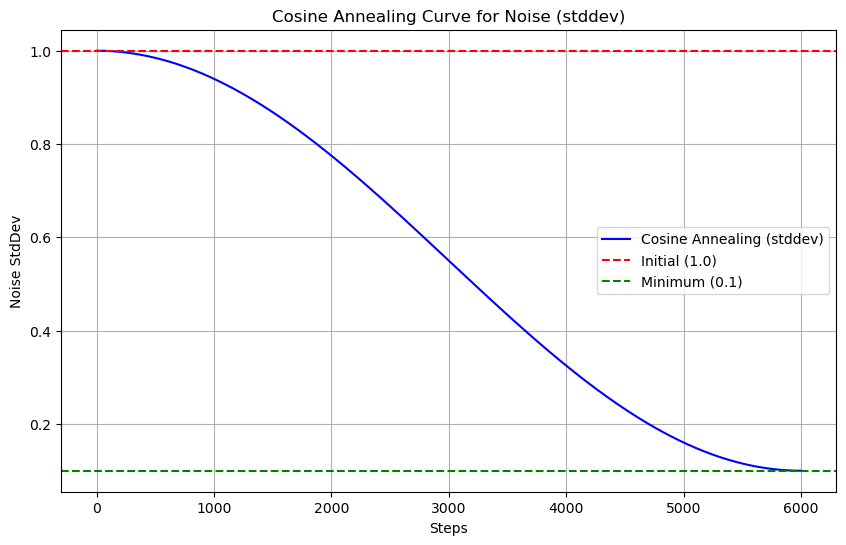

In [12]:
T_max = 6000  # Total steps
eta_max = 1.0  # Initial noise stddev
eta_min = 0.1  # Minimum noise stddev

t = np.linspace(0, T_max, 1000)  # Sample points
value = eta_min + 0.5 * (eta_max - eta_min) * (1 + np.cos(t * np.pi / T_max))

plt.figure(figsize=(10, 6))
plt.plot(t, value, 'b-', label='Cosine Annealing (stddev)')
plt.axhline(y=eta_max, color='r', linestyle='--', label='Initial (1.0)')
plt.axhline(y=eta_min, color='g', linestyle='--', label='Minimum (0.1)')
plt.xlabel('Steps')
plt.ylabel('Noise StdDev')
plt.title('Cosine Annealing Curve for Noise (stddev)')
plt.legend()
plt.grid(True)
plt.show()

In [3]:
import sys
print(sys.path)  # Shows all directories Python checks for imports

# Try to find mcp specifically
try:
    import mcp
    print(f"MCP found at: {mcp.__file__}")
except ImportError:
    print("MCP not found")

['/workspaces/RL_Agents/src/app', '/opt/conda/envs/rl_env/lib/python310.zip', '/opt/conda/envs/rl_env/lib/python3.10', '/opt/conda/envs/rl_env/lib/python3.10/lib-dynload', '', '/opt/conda/envs/rl_env/lib/python3.10/site-packages']
MCP found at: /opt/conda/envs/rl_env/lib/python3.10/site-packages/mcp/__init__.py


In [2]:
import mcp
print(dir(mcp))  # This will show all available attributes/modules in mcp

['CallToolRequest', 'ClientCapabilities', 'ClientNotification', 'ClientRequest', 'ClientResult', 'ClientSession', 'CompleteRequest', 'CreateMessageRequest', 'CreateMessageResult', 'ErrorData', 'GetPromptRequest', 'GetPromptResult', 'Implementation', 'IncludeContext', 'InitializeRequest', 'InitializeResult', 'InitializedNotification', 'JSONRPCError', 'JSONRPCRequest', 'JSONRPCResponse', 'ListPromptsRequest', 'ListPromptsResult', 'ListResourcesRequest', 'ListResourcesResult', 'ListToolsResult', 'LoggingLevel', 'LoggingMessageNotification', 'McpError', 'Notification', 'PingRequest', 'ProgressNotification', 'PromptsCapability', 'ReadResourceRequest', 'ReadResourceResult', 'Resource', 'ResourceUpdatedNotification', 'ResourcesCapability', 'RootsCapability', 'SamplingMessage', 'SamplingRole', 'ServerCapabilities', 'ServerNotification', 'ServerRequest', 'ServerResult', 'ServerSession', 'SetLevelRequest', 'StdioServerParameters', 'StopReason', 'SubscribeRequest', 'Tool', 'ToolsCapability', 'Uns